In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import scipy.interpolate as interp
import time
from tqdm import tqdm
from IPython import display
import scipy.optimize as opt

import tensorflow as tf
print(tf. __version__)

import matplotlib
cmap_NN = matplotlib.colormaps['Reds']
cmap_RMSA = matplotlib.colormaps['Blues']

2.10.0


## Load model

In [2]:
from SQ_NN import SQ_NN, SQ_NN_tf, Decoder_aug, sm_GP
from RMSA import RMSA
q_rs = (np.arange(80)+1)*0.2
def SQ_RMSA(parameters):
    return (RMSA(q_rs, 0.5, scl=parameters[1], gamma=parameters[2]*np.exp(1/parameters[1]), eta=parameters[0])[1])

## Define functions

In [3]:
def hardsphere(q,sigma=1):
    R = sigma/2
    P = (3*(np.sin(q*R)-q*R*np.cos(q*R))/(q*R)**3)**2
    return P

def scale(q,x,scale):
    qs = q*scale
    f_interp = interp.interp1d(qs, x, fill_value='extrapolate')
    x_interp = f_interp(q)
    return x_interp

def IQ_resoln(Q, Q_fine, IQ_th, dQ):
    '''
    Q: Q of the instrument resolution function
    Q_fine: A set of smooth Q points
    IQ_th: I(Q), interpolated to Q_fine
    dQ: The instrument resolution function
    '''
    
    Qmean = Q
    N = len(Q)
    IQ = []
    
    for i in range(N):
        current_dQ = dQ[i]
        current_Qmean = Qmean[i]
        w_gauss = (1/np.sqrt(2*np.pi*current_dQ**2))*np.exp(-(Q_fine-current_Qmean)**2/(2*current_dQ**2))
        IQ_resoln = IQ_th*w_gauss
        
        IQ.append(np.trapz(IQ_resoln,Q_fine)/np.trapz(w_gauss,Q_fine))

    IQ_out = np.array(IQ)
    return IQ_out

def SQ_th(sq_func,fp):
    # structure factor
    return sq_func(fp[0:3])

def IQ_th(sq_func,fp):
    # form factor
    P = hardsphere(q,1)

    # structure factor
    S = SQ_th(sq_func,fp)

    # I(Q)
    IQ = S*P*fp[4]+fp[5]

    # resolution
    Q = q_EQSANS
    dQ = qsig_EQSANS
    Q_fine = np.linspace(0.2,16,100)

    f_interp = interp.interp1d(q,IQ)
    IQ_Qfine = f_interp(Q_fine)
    IQ_res = IQ_resoln(Q, Q_fine, IQ_Qfine, dQ)

    IQ_res_scale = scale(Q,IQ_res,fp[3])
    f_interp = interp.interp1d(Q,IQ_res_scale)
    
    IQ_res_scale_interp = f_interp(q_rs)
    return IQ_res_scale_interp

## Load data

In [4]:
# Training set
parameters_zscore = 0
sq_min = np.exp(-5) # minimum of sq

if 1:
    X_file = './training_set/input_grid_all_GPR80.csv'
    Y_file = './training_set/target_grid_all.csv'
else:
    X_file = './training_set/input_random_all_GPR80.csv'
    Y_file = './training_set/target_random_all.csv'
    
fX = open(X_file, 'r', encoding='utf-8-sig')
sq = np.genfromtxt(fX, delimiter=',').astype(np.float32)
sq[sq<=0] = sq_min

fY = open(Y_file, 'r', encoding='utf-8-sig')
target = np.genfromtxt(fY, delimiter=',').astype(np.float32)

eta = target[:,0]
kappa = target[:,1]
Z = target[:,3]
A = target[:,2]
lnZ = np.log(Z)
lnA = np.log(A)

eta_mean = np.mean(eta)
eta_std = np.std(eta)
kappa_mean = np.mean(kappa)
kappa_std = np.std(kappa)
A_mean = np.mean(A)
A_std = np.std(A)

# normalization
eta_z = (eta-eta_mean)/eta_std
kappa_z = (kappa-kappa_mean)/kappa_std
A_z = (A-A_mean)/A_std

if parameters_zscore:
    parameters_train = np.array([eta_z,kappa_z,A_z]).T
else:
    parameters_train = np.array([eta,kappa,A]).T

sq_dim = sq.shape[1]
sample_train_dim = sq.shape[0]
q = (np.arange(sq_dim)+1)*0.2
q_rs = (np.arange(sq_dim)+1)*0.2
q_rs_dim = q_rs.shape[0]

# rescale
r_eta = 1
sq_rs = np.zeros((sample_train_dim,q_rs_dim),dtype='float32')
for i in range(sample_train_dim):
    qr_eta = q*r_eta
    interpolating_function = interp.interp1d(qr_eta[3:],sq[i,3:],fill_value='extrapolate')
    sq_rs[i,:] = interpolating_function(q_rs).astype(np.float32)
sq_rs[sq_rs<=0] = sq_min

print('eta ~ N({:0.4f},{:0.4f})'.format(np.mean(eta),np.var(eta)))
print('kappa ~ N({:0.4f},{:0.4f})'.format(np.mean(kappa),np.var(kappa)))
print('A ~ N({:0.4f},{:0.4f})'.format(np.mean(A),np.var(A)))

eta ~ N(0.2325,0.0169)
kappa ~ N(0.2600,0.0208)
A ~ N(13.0000,52.0000)


### resolution

In [5]:
# from scipy.io import loadmat
# filename_EQSANS = './EQSANS.mat'
# loaded_EQSANS = loadmat(filename_EQSANS)
# q_EQSANS_0 = loaded_EQSANS['Q_real'][:,0]#.astype('float32')
# qsig_EQSANS = loaded_EQSANS['qsig'][:,0]#.astype('float32')
# data = loaded_EQSANS['data']#.astype('float32')
# qsig_EQSANS[qsig_EQSANS==0] = np.ones(np.sum(qsig_EQSANS==0))*np.min(qsig_EQSANS[qsig_EQSANS!=0])
# q_EQSANS = q_EQSANS_0*16/max(q_EQSANS_0)
# qsig_EQSANS = qsig_EQSANS*16/max(q_EQSANS_0)

data_EQSANS = np.loadtxt('./EQSANS.txt',delimiter=',',skiprows=2)
q_EQSANS_0 = data_EQSANS[:,0]#.astype('float32')
qsig_EQSANS = data_EQSANS[:,3]#.astype('float32')
IQ_EQSANS = data_EQSANS[:,1]#.astype('float32')
E_EQSANS = data_EQSANS[:,2]#.astype('float32')

qsig_EQSANS[qsig_EQSANS==0] = np.ones(np.sum(qsig_EQSANS==0))*np.min(qsig_EQSANS[qsig_EQSANS!=0])
q_EQSANS = q_EQSANS_0*16/max(q_EQSANS_0)
qsig_EQSANS = qsig_EQSANS*16/max(q_EQSANS_0)

## Select data and produce I(Q)

In [6]:
print('\neta in')
print(np.unique(eta))
print('\nkappa in')
print(np.unique(kappa))
print('\nA in')
print(np.unique(A))


eta in
[0.015 0.03  0.045 0.06  0.075 0.09  0.105 0.12  0.135 0.15  0.165 0.18
 0.195 0.21  0.225 0.24  0.255 0.27  0.285 0.3   0.315 0.33  0.345 0.36
 0.375 0.39  0.405 0.42  0.435 0.45 ]

kappa in
[0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28
 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5 ]

A in
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25.]


In [7]:
# indexing
def id_params(parameters):
    tol = 1e-6
    id_eta = np.abs(eta-parameters[0])<tol
    id_kappa = np.abs(kappa-parameters[1])<tol
    id_A = np.abs(A-parameters[2])<tol
    return np.where(id_eta*id_kappa*id_A)[0]

In [8]:
eta_list = np.array([0.045,0.135,0.225,0.315,0.405])
kappa_list = np.array([0.1,0.2,0.3,0.4,0.5])
A_list = np.array([1,3,6,10,20])

In [9]:
def IQ_exp(sq_GT,fp):
    # form factor
    P = hardsphere(q,1)

    # structure factor
    S = sq_GT

    # I(Q)
    IQ = S*P*fp[4]+fp[5]

    # resolution
    Q = q_EQSANS
    dQ = qsig_EQSANS
    Q_fine = np.linspace(0.2,16,100)

    f_interp = interp.interp1d(q,IQ)
    IQ_Qfine = f_interp(Q_fine)
    IQ_res = IQ_resoln(Q, Q_fine, IQ_Qfine, dQ)

    IQ_res_scale = scale(Q,IQ_res,fp[3])
    f_interp = interp.interp1d(Q,IQ_res_scale)

    IQ_exp = f_interp(q_rs)
    return IQ_exp


In [10]:
def Z(A,kappa):
    return np.sqrt(A*(1+1/2/kappa)**2)    

from scipy.special import lambertw as lambertw
def xV(A,kappa):
    return kappa*lambertw(A/kappa*np.exp(1/kappa))
            
def log_Aeta(A,kappa,eta):
    r_eta = (np.pi/6*eta)**(-1/3)
    return np.log(A) - np.log(r_eta) + (-(r_eta-1)/kappa)

def Z_err(A,kappa,A_err,kappa_err,delta = 1e-3):
    dZ_dA = (Z(A*(1+delta),kappa)-Z(A,kappa))/(A*delta)
    dZ_dkappa = (Z(A,kappa*(1+delta))-Z(A,kappa))/(kappa*delta)
    
    Z_err = np.sqrt((dZ_dA*A_err)**2 + (dZ_dkappa*kappa_err)**2)
    return Z_err

def xV_err(A,kappa,A_err,kappa_err,delta = 1e-3):
    dxV_dA = (xV(A*(1+delta),kappa)-xV(A,kappa))/(A*delta)
    dxV_dkappa = (xV(A,kappa*(1+delta))-xV(A,kappa))/(kappa*delta)
    
    xV_err = np.sqrt((dxV_dA*A_err)**2 + (dxV_dkappa*kappa_err)**2)
    return xV_err

def log_Aeta_err(A,kappa,eta,A_err,kappa_err,eta_err,delta = 1e-3):
    dy_dA = (log_Aeta(A*(1+delta),kappa,eta)-log_Aeta(A,kappa,eta))/(A*delta)
    dy_dkappa = (log_Aeta(A,kappa*(1+delta),eta)-log_Aeta(A,kappa,eta))/(kappa*delta)
    dy_deta = (log_Aeta(A,kappa,eta*(1+delta))-log_Aeta(A,kappa,eta))/(eta*delta)
    
    y_err = np.sqrt((dy_dA*A_err)**2 + (dy_dkappa*kappa_err)**2 + (dy_deta*eta_err)**2)
    return y_err

## eta

In [11]:
parameters_list = np.array([[eta_list[i],kappa_list[2],A_list[2]] for i in range(len(eta_list))])

fp_GT_list = [np.r_[p,np.array([1,1,0.01])] for p in parameters_list]

SQ_exp_GT_list = [sq_rs[id_params(p),:][0] for p in parameters_list]

# sq_NN = SQ_NN(parameters)
# sq_NN_GP = SQ_NN(parameters,GP=True)
# sq_RMSA = SQ_RMSA(parameters)[1]

In [12]:
dict_eta = {'fp_GT_list':fp_GT_list,'SQ_exp_GT_list':SQ_exp_GT_list,}

## kappa

In [13]:
parameters_list = np.array([[eta_list[2],kappa_list[i],A_list[2]] for i in range(len(kappa_list))])

fp_GT_list = [np.r_[p,np.array([1,1,0.01])] for p in parameters_list]

SQ_exp_GT_list = [sq_rs[id_params(p),:][0] for p in parameters_list]

# sq_NN = SQ_NN(parameters)
# sq_NN_GP = SQ_NN(parameters,GP=True)
# sq_RMSA = SQ_RMSA(parameters)[1]

In [14]:
dict_kappa = {'fp_GT_list':fp_GT_list,'SQ_exp_GT_list':SQ_exp_GT_list,}

## A

In [15]:
parameters_list = np.array([[eta_list[2],kappa_list[2],A_list[i]] for i in range(len(A_list))])

fp_GT_list = [np.r_[p,np.array([1,1,0.01])] for p in parameters_list]

SQ_exp_GT_list = [sq_rs[id_params(p),:][0] for p in parameters_list]

# sq_NN = SQ_NN(parameters)
# sq_NN_GP = SQ_NN(parameters,GP=True)
# sq_RMSA = SQ_RMSA(parameters)[1]

In [16]:
dict_A = {'fp_GT_list':fp_GT_list,'SQ_exp_GT_list':SQ_exp_GT_list,}

# Plot results

In [17]:
markers = ['o','x','s','+','^']

## eta

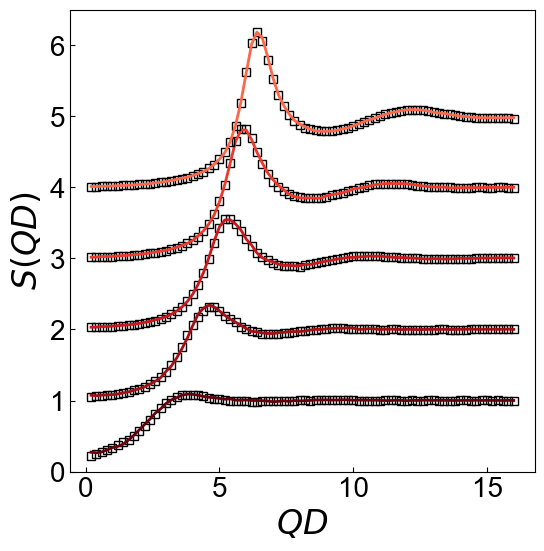

In [50]:
fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

for i in range(len(parameters_list)):
    fp_GT = dict_eta['fp_GT_list'][i]

    r = (1-(fp_GT[0]-eta_list[0])/(eta_list[-1]-eta_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    SQ_exp_GT = dict_eta['SQ_exp_GT_list'][i]+i
    SQ_exp_NN = SQ_NN(fp_GT)+i
    SQ_exp_RMSA = SQ_RMSA(fp_GT)+i

#     ax.plot(q,SQ_exp_GT,
#             '-k', lw=2, label='ground truth')
    ax.plot(q,SQ_exp_GT,
            's', color='k', fillstyle='none', lw=2, label='ground truth')
    ax.plot(q,SQ_exp_NN,
            '-', lw=2, label='NN', color=c_NN)
#     ax.plot(q,SQ_exp_RMSA,
#             '--', lw=2, label='RMSA', color=c_RMSA)

ax.set_xlabel(r'$QD$',fontsize=24)
ax.set_ylabel(r'$S(QD)$',fontsize=24)
ax.tick_params(direction='in', axis='both', which='both', labelsize=20)
# ax.set_yscale('log')
ax.set_ylim([0,6.5])

plt.show()

## kappa

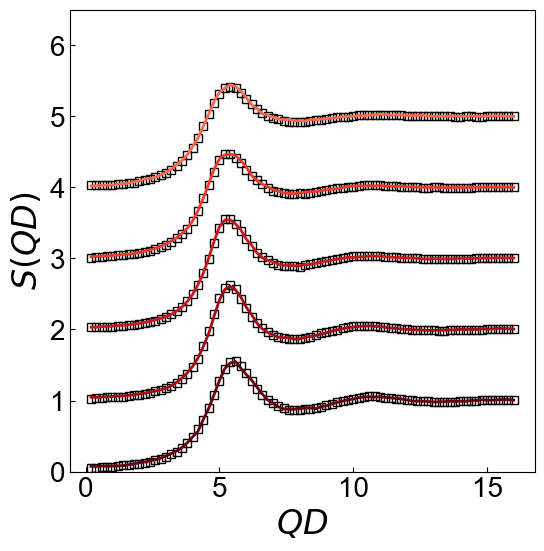

In [51]:
fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

for i in range(len(parameters_list)):
    fp_GT = dict_kappa['fp_GT_list'][i]
    
    r = (1-(fp_GT[1]-kappa_list[0])/(kappa_list[-1]-kappa_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    SQ_exp_GT = dict_kappa['SQ_exp_GT_list'][i]+i
    SQ_exp_NN = SQ_NN(fp_GT)+i
    SQ_exp_RMSA = SQ_RMSA(fp_GT)+i

#     ax.plot(q,SQ_exp_GT,
#             '-k', lw=2, label='ground truth')
    ax.plot(q,SQ_exp_GT,
            's', color='k', fillstyle='none', lw=2, label='ground truth')
    ax.plot(q,SQ_exp_NN,
            '-', lw=2, label='NN', color=c_NN)
#     ax.plot(q,SQ_exp_RMSA,
#             '--', lw=2, label='RMSA', color=c_RMSA)

ax.set_xlabel(r'$QD$',fontsize=24)
ax.set_ylabel(r'$S(QD)$',fontsize=24)
ax.tick_params(direction='in', axis='both', which='both', labelsize=20)
# ax.set_yscale('log')
ax.set_ylim([0,6.5])

plt.show()

## A

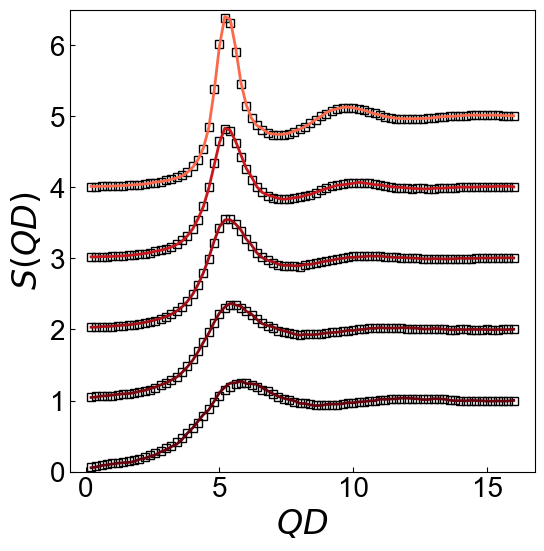

In [53]:
fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

for i in range(len(parameters_list)):
    fp_GT = dict_A['fp_GT_list'][i]
    
    r = (1-(fp_GT[2]-A_list[0])/(A_list[-1]-A_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    SQ_exp_GT = dict_A['SQ_exp_GT_list'][i]+i
    SQ_exp_NN = SQ_NN(fp_GT)+i
    SQ_exp_RMSA = SQ_RMSA(fp_GT)+i

#     ax.plot(q,SQ_exp_GT,
#             '-k', lw=2, label='ground truth')
    ax.plot(q,SQ_exp_GT,
            's', color='k', fillstyle='none', lw=2, label='ground truth')
    ax.plot(q,SQ_exp_NN,
            '-', lw=2, label='NN', color=c_NN)
#     ax.plot(q,SQ_exp_RMSA,
#             '--', lw=2, label='RMSA', color=c_RMSA)

ax.set_xlabel(r'$QD$',fontsize=24)
ax.set_ylabel(r'$S(QD)$',fontsize=24)
ax.tick_params(direction='in', axis='both', which='both', labelsize=20)
# ax.set_yscale('log')
ax.set_ylim([0,6.5])

plt.show()

## fitting curve and residual

In [22]:
from scipy.io import loadmat
from glob import glob

index_q = np.arange(40)*2

def load_SQ_MD(filename):
    data = np.genfromtxt(filename)
    n_particles = 16384
    Q_data = data[10:,0]
    SQ_data = data[10:,1]*n_particles

    f_interp = interp.interp1d(Q_data,SQ_data,kind='nearest',fill_value='extrapolate')
    SQ_MD = f_interp(q)
    
    return SQ_MD

### eta

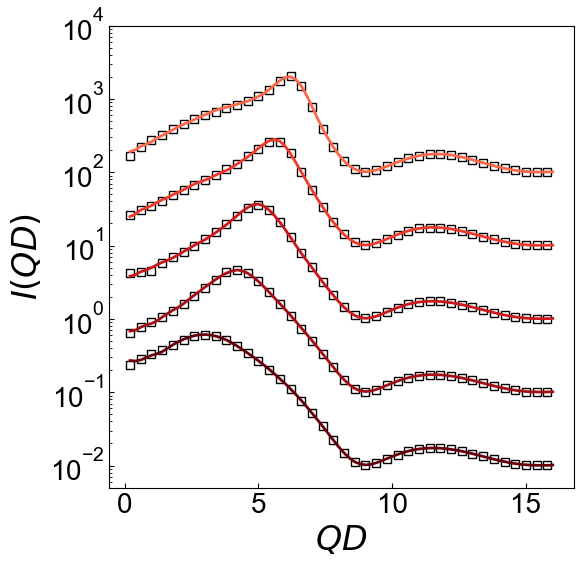

In [54]:
# NN and RMSA fitting curve
dict_eta = loadmat('fp_eta_fix.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)

for i in range(len(parameters_list)):
    fp_GT = dict_eta['fp_GT_list'][i]
    IQ_exp_GT = dict_eta['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_eta['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_eta['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[0]-eta_list[0])/(eta_list[-1]-eta_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
    ax.plot(q[index_q],IQ_exp_GT[index_q]*10**i,
            's', color='k', fillstyle='none', lw=2, alpha=1,
            label='ground truth')
#     ax.errorbar(q[index_q],IQ_exp_GT[index_q]*10**i,IQ_exp_GT[index_q]*10**i*0.1,
#             alpha=1,fmt='none',color='k',capsize=2.0)

#     ax.plot(q,IQ_exp_GT*10**i,'-k',lw=2,
#             label='ground truth')
    index_q = np.arange(40)*2
#     ax.plot(q,IQ_MD*10**i,
#             ':', lw=2, label='NN_MD', color=c_NN)
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*10**i,'-',
            label='NN', color=c_NN, lw=2)
#     ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'-',
#             label='RMSA', color=c_RMSA, lw=2)


    ax.set_yscale('log')
    ax.set_ylim([5e-3,1e4])
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=24)
ax.set_ylabel(r'$I(QD)$',fontsize=24)
ax.tick_params(direction='in', axis='both', which='both', labelsize=20)

plt.show()

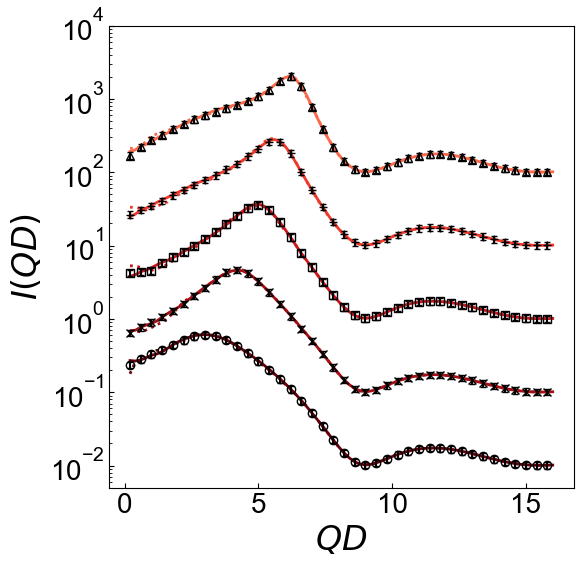

In [24]:
# NN fitting curve and MD invertion
dict_eta = loadmat('fp_eta_fix.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)

for i in range(len(parameters_list)):
    fp_GT = dict_eta['fp_GT_list'][i]
    IQ_exp_GT = dict_eta['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_eta['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_eta['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[0]-eta_list[0])/(eta_list[-1]-eta_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
#     ax.plot(q,IQ_exp_GT*10**i,'-k',lw=2,
#             label='ground truth')
    index_q = np.arange(40)*2
    ax.plot(q,IQ_MD*10**i,
            ':', lw=2, label='NN_MD', color=c_NN)
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*10**i,'-',
            label='NN', color=c_NN, lw=2)
#     ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'-',
#             label='RMSA', color=c_RMSA, lw=2)
    
    ax.plot(q[index_q],IQ_exp_GT[index_q]*10**i,
            markers[i], color='k', fillstyle='none', lw=2, alpha=1,
            label='ground truth')
    ax.errorbar(q[index_q],IQ_exp_GT[index_q]*10**i,IQ_exp_GT[index_q]*10**i*0.1,
            alpha=1,fmt='none',color='k',capsize=2.0)

    ax.set_yscale('log')
    ax.set_ylim([5e-3,1e4])
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=24)
ax.set_ylabel(r'$I(QD)$',fontsize=24)
ax.tick_params(direction='in', axis='both', which='both', labelsize=20)

plt.show()

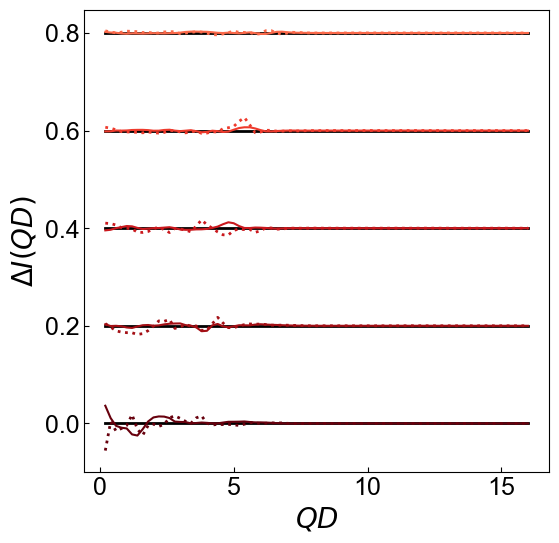

In [25]:
# NN fitting curve and MD invertion: residual
dict_eta = loadmat('fp_eta_fix.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)

for i in range(len(parameters_list)):
    fp_GT = dict_eta['fp_GT_list'][i]
    IQ_exp_GT = dict_eta['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_eta['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_eta['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[0]-eta_list[0])/(eta_list[-1]-eta_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
    shift = 0.2
    ax.plot(q,IQ_exp_GT-IQ_exp_GT+i*shift,'-k',lw=2,
            label='ground truth')
    ax.plot(q,IQ_MD-IQ_exp_GT+i*shift,
            ':', lw=2, label='NN_MD', color=c_NN)
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)-IQ_exp_GT+i*shift,'-',
            label='NN', color=c_NN)
#     ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'--',
#             label='RMSA', color=c_RMSA)

#     ax.plot(q[index_q],IQ_exp_GT[index_q]*0+i*shift,
#             markers[i], color='k', fillstyle='none', lw=2, alpha=1,
#             label='ground truth')
#     ax.errorbar(q[index_q],IQ_exp_GT[index_q]*0+i*shift,IQ_exp_GT[index_q]*0.01,
#             alpha=1,fmt='none',color='k',capsize=2.0)

#     ax.set_yscale('log')
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=20)
ax.set_ylabel(r'$\Delta I(QD)$',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18)

plt.show()

### kappa

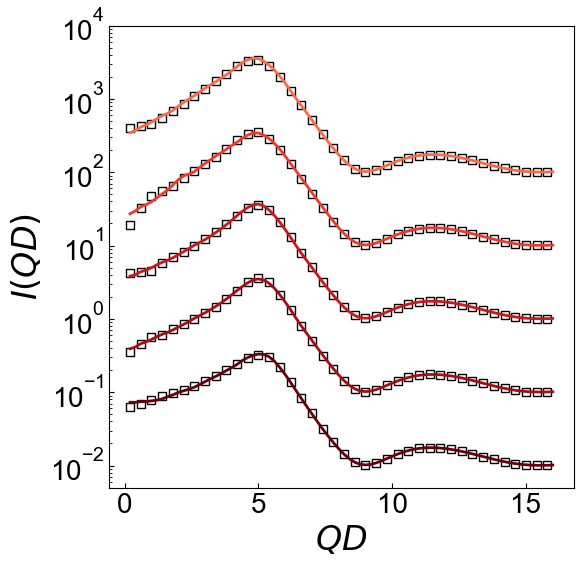

In [55]:
# NN and RMSA fitting curve
dict_kappa = loadmat('fp_kappa_fix.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)+5

for i in range(len(parameters_list)):
    fp_GT = dict_kappa['fp_GT_list'][i]
    IQ_exp_GT = dict_kappa['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_kappa['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_kappa['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[1]-kappa_list[0])/(kappa_list[-1]-kappa_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
    ax.plot(q[index_q],IQ_exp_GT[index_q]*10**i,
            's', color='k', fillstyle='none', lw=2, alpha=1,
            label='ground truth')
#     ax.errorbar(q[index_q],IQ_exp_GT[index_q]*10**i,IQ_exp_GT[index_q]*10**i*0.1,
#             alpha=1,fmt='none',color='k',capsize=2.0)

#     ax.plot(q,IQ_exp_GT*10**i,'-k',lw=2,
#             label='ground truth')
    index_q = np.arange(40)*2
#     ax.plot(q,IQ_MD*10**i,
#             ':', lw=2, label='NN_MD', color=c_NN)
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*10**i,'-',
            label='NN', color=c_NN, lw=2)
#     ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'-',
#             label='RMSA', color=c_RMSA, lw=2)


    ax.set_yscale('log')
    ax.set_ylim([5e-3,1e4])
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=24)
ax.set_ylabel(r'$I(QD)$',fontsize=24)
ax.tick_params(direction='in', axis='both', which='both', labelsize=20)

plt.show()

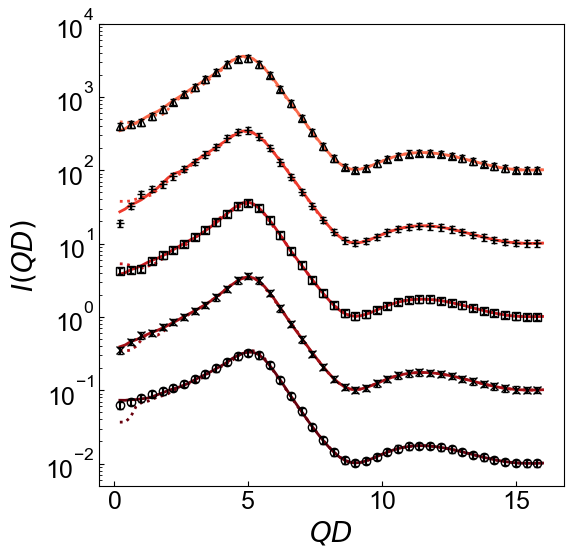

In [27]:
# NN fitting curve and MD invertion
dict_kappa = loadmat('fp_kappa_fix.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)+5

for i in range(len(parameters_list)):
    fp_GT = dict_kappa['fp_GT_list'][i]
    IQ_exp_GT = dict_kappa['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_kappa['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_kappa['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[1]-kappa_list[0])/(kappa_list[-1]-kappa_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
#     ax.plot(q,IQ_exp_GT*10**i,'-k',lw=2,
#             label='ground truth')
    index_q = np.arange(40)*2
    ax.plot(q,IQ_MD*10**i,
            ':', lw=2, label='NN_MD', color=c_NN)
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*10**i,'-',
            label='NN', color=c_NN, lw=2)
#     ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'-',
#             label='RMSA', color=c_RMSA, lw=2)
    
    ax.plot(q[index_q],IQ_exp_GT[index_q]*10**i,
            markers[i], color='k', fillstyle='none', lw=2, alpha=1,
            label='ground truth')
    ax.errorbar(q[index_q],IQ_exp_GT[index_q]*10**i,IQ_exp_GT[index_q]*10**i*0.1,
            alpha=1,fmt='none',color='k',capsize=2.0)

    ax.set_yscale('log')
    ax.set_ylim([5e-3,1e4])
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=20)
ax.set_ylabel(r'$I(QD)$',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18)

plt.show()

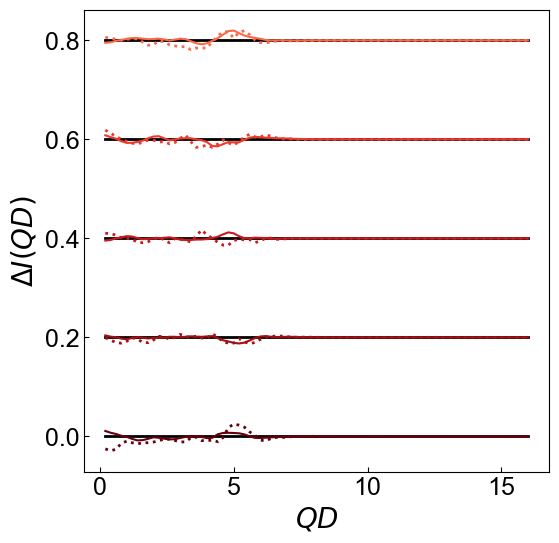

In [28]:
# NN fitting curve and MD invertion: residual
dict_kappa = loadmat('fp_kappa_fix.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)+5

for i in range(len(parameters_list)):
    fp_GT = dict_kappa['fp_GT_list'][i]
    IQ_exp_GT = dict_kappa['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_kappa['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_kappa['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[1]-kappa_list[0])/(kappa_list[-1]-kappa_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
    shift = 0.2
    ax.plot(q,IQ_exp_GT-IQ_exp_GT+i*shift,'-k',lw=2,
            label='ground truth')
    ax.plot(q,IQ_MD-IQ_exp_GT+i*shift,
            ':', lw=2, label='NN_MD', color=c_NN)
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)-IQ_exp_GT+i*shift,'-',
            label='NN', color=c_NN)
#     ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'--',
#             label='RMSA', color=c_RMSA)

#     ax.plot(q[index_q],IQ_exp_GT[index_q]*0+i*shift,
#             markers[i], color='k', fillstyle='none', lw=2, alpha=1,
#             label='ground truth')
#     ax.errorbar(q[index_q],IQ_exp_GT[index_q]*0+i*shift,IQ_exp_GT[index_q]*0.01,
#             alpha=1,fmt='none',color='k',capsize=2.0)

#     ax.set_yscale('log')
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=20)
ax.set_ylabel(r'$\Delta I(QD)$',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18)

plt.show()

### A

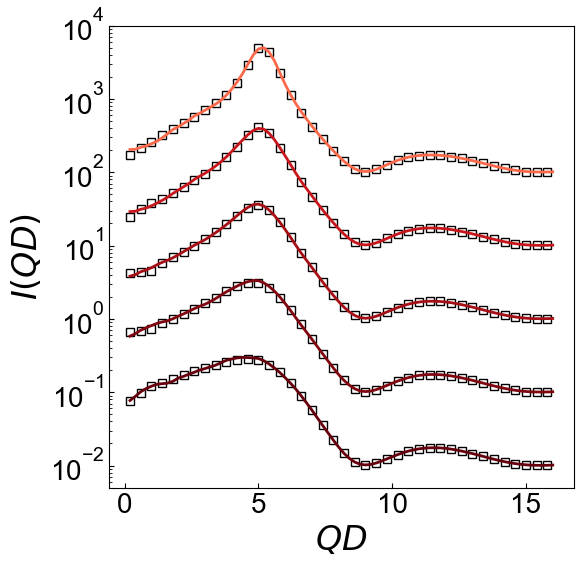

In [56]:
# NN and RMSA fitting curve
dict_A = loadmat('fp_A_fix.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)+10

for i in range(len(parameters_list)):
    fp_GT = dict_A['fp_GT_list'][i]
    IQ_exp_GT = dict_A['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_A['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_A['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[2]-A_list[0])/(A_list[-1]-A_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
    ax.plot(q[index_q],IQ_exp_GT[index_q]*10**i,
            's', color='k', fillstyle='none', lw=2, alpha=1,
            label='ground truth')
#     ax.errorbar(q[index_q],IQ_exp_GT[index_q]*10**i,IQ_exp_GT[index_q]*10**i*0.1,
#             alpha=1,fmt='none',color='k',capsize=2.0)

#     ax.plot(q,IQ_exp_GT*10**i,'-k',lw=2,
#             label='ground truth')
    index_q = np.arange(40)*2
#     ax.plot(q,IQ_MD*10**i,
#             ':', lw=2, label='NN_MD', color=c_NN)
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*10**i,'-',
            label='NN', color=c_NN, lw=2)
#     ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'-',
#             label='RMSA', color=c_RMSA, lw=2)


    ax.set_yscale('log')
    ax.set_ylim([5e-3,1e4])
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=24)
ax.set_ylabel(r'$I(QD)$',fontsize=24)
ax.tick_params(direction='in', axis='both', which='both', labelsize=20)

plt.show()

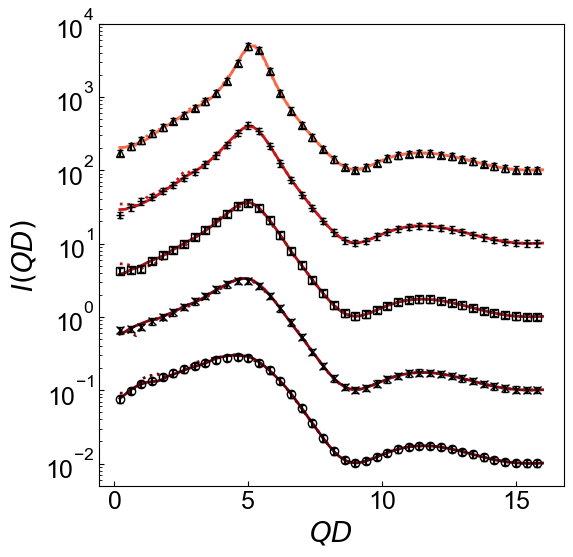

In [57]:
# NN fitting curve and MD invertion
dict_A = loadmat('fp_A_fix.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)+10

for i in range(len(parameters_list)):
    fp_GT = dict_A['fp_GT_list'][i]
    IQ_exp_GT = dict_A['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_A['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_A['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[2]-A_list[0])/(A_list[-1]-A_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
#     ax.plot(q,IQ_exp_GT*10**i,'-k',lw=2,
#             label='ground truth')
    index_q = np.arange(40)*2
    ax.plot(q,IQ_MD*10**i,
            ':', lw=2, label='NN_MD', color=c_NN)
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*10**i,'-',
            label='NN', color=c_NN, lw=2)
#     ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'-',
#             label='RMSA', color=c_RMSA, lw=2)
    
    ax.plot(q[index_q],IQ_exp_GT[index_q]*10**i,
            markers[i], color='k', fillstyle='none', lw=2, alpha=1,
            label='ground truth')
    ax.errorbar(q[index_q],IQ_exp_GT[index_q]*10**i,IQ_exp_GT[index_q]*10**i*0.1,
            alpha=1,fmt='none',color='k',capsize=2.0)

    ax.set_yscale('log')
    ax.set_ylim([5e-3,1e4])
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=20)
ax.set_ylabel(r'$I(QD)$',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18)

plt.show()

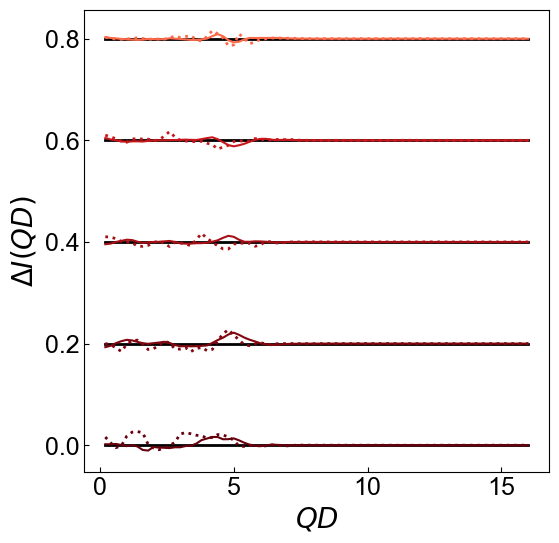

In [30]:
# NN fitting curve and MD invertion: residual
dict_A = loadmat('fp_A_fix.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)+10

for i in range(len(parameters_list)):
    fp_GT = dict_A['fp_GT_list'][i]
    IQ_exp_GT = dict_A['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_A['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_A['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[2]-A_list[0])/(A_list[-1]-A_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
    shift = 0.2
    ax.plot(q,IQ_exp_GT-IQ_exp_GT+i*shift,'-k',lw=2,
            label='ground truth')
    ax.plot(q,IQ_MD-IQ_exp_GT+i*shift,
            ':', lw=2, label='NN_MD', color=c_NN)
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)-IQ_exp_GT+i*shift,'-',
            label='NN', color=c_NN)
#     ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'--',
#             label='RMSA', color=c_RMSA)

#     ax.plot(q[index_q],IQ_exp_GT[index_q]*0+i*shift,
#             markers[i], color='k', fillstyle='none', lw=2, alpha=1,
#             label='ground truth')
#     ax.errorbar(q[index_q],IQ_exp_GT[index_q]*0+i*shift,IQ_exp_GT[index_q]*0.01,
#             alpha=1,fmt='none',color='k',capsize=2.0)

#     ax.set_yscale('log')
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=20)
ax.set_ylabel(r'$\Delta I(QD)$',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18)

plt.show()

## Inverted V(r)

In [31]:
rr = np.linspace(0.01, 10.0, 200)
ur_hc = 4*500*((2**(1/6)/rr)**12-(2**(1/6)/rr)**6-0.25)
ur_hc[rr>=1] = 0

def sample_potential(fp,fp_err):
    n_sample = 100
    
    kappa = fp[1]
    kappa_std = fp_err[1]
    A = fp[2]
    A_std = fp_err[2]
    
    ur_sample = np.zeros((tf.size(rr),n_sample))
    for i in range(n_sample):
        kappa_sample = np.random.normal()*(kappa_std) + kappa
        A_sample = np.random.normal()*(A_std) + A
        ur_sample[:,i] = A_sample*np.exp(-(rr-1)/kappa_sample)/rr + ur_hc
        
    ur_std = np.std(ur_sample,axis=1)
    ur_mean = np.mean(ur_sample,axis=1)
        
    return ur_mean, ur_std

def sample_potential_GT(fp):
    kappa = fp[1]
    A = fp[2]
    
    ur = A*np.exp(-(rr-1)/kappa)/rr + ur_hc
        
    return ur

### eta

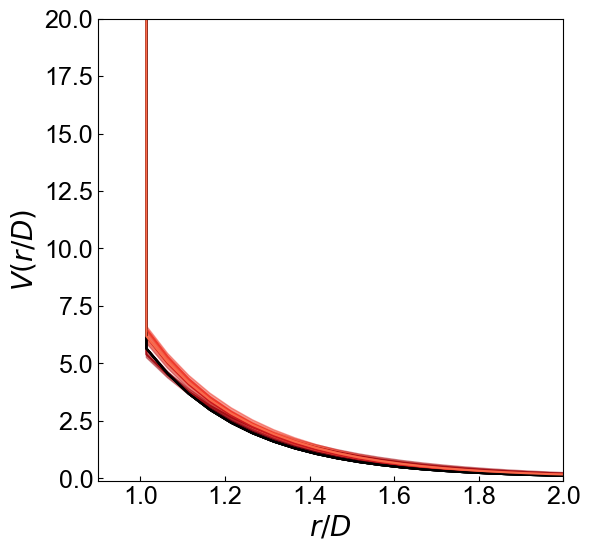

In [32]:
# V(r)
dict_eta = loadmat('fp_eta_fix.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)

for i in range(len(parameters_list)):
    fp_GT = dict_eta['fp_GT_list'][i]
    fp_opt_NN = dict_eta['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_eta['fp_opt_RMSA_list'][i]
    fp_err_NN = dict_eta['fp_err_NN_list'][i]
    fp_err_RMSA = dict_eta['fp_err_RMSA_list'][i]
    
    r = (1-(fp_GT[0]-eta_list[0])/(eta_list[-1]-eta_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    ur_GT = sample_potential_GT(fp_GT)
    ur_NN, ur_NN_std = sample_potential(fp_opt_NN,fp_err_NN)
    
    ax.fill_between(rr,ur_NN+ur_NN_std,ur_NN-ur_NN_std,color=c_NN,alpha=0.5)
    ax.plot(rr,ur_GT,'k')
    ax.plot(rr,ur_NN,color=c_NN)

ax.set_xlim(0.9,2.0)
ax.set_ylim(-0.1,20)
ax.set_xlabel(r'$r/D$',fontsize=20)
ax.set_ylabel(r'$V(r/D)$',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18)

plt.show()

### kappa

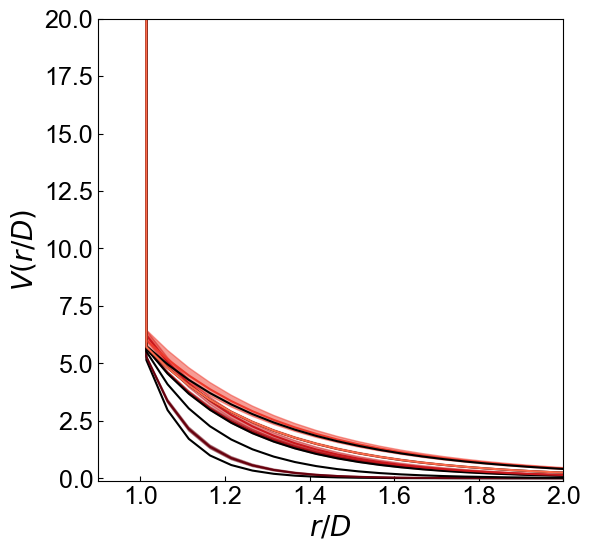

In [33]:
# V(r)
dict_kappa = loadmat('fp_kappa_fix.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)

for i in range(len(parameters_list)):
    fp_GT = dict_kappa['fp_GT_list'][i]
    fp_opt_NN = dict_kappa['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_kappa['fp_opt_RMSA_list'][i]
    fp_err_NN = dict_kappa['fp_err_NN_list'][i]
    fp_err_RMSA = dict_kappa['fp_err_RMSA_list'][i]
    
    r = (1-(fp_GT[1]-kappa_list[0])/(kappa_list[-1]-kappa_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    ur_GT = sample_potential_GT(fp_GT)
    ur_NN, ur_NN_std = sample_potential(fp_opt_NN,fp_err_NN)
    
    ax.fill_between(rr,ur_NN+ur_NN_std,ur_NN-ur_NN_std,color=c_NN,alpha=0.5)
    ax.plot(rr,ur_GT,'k')
    ax.plot(rr,ur_NN,color=c_NN)

ax.set_xlim(0.9,2.0)
ax.set_ylim(-0.1,20)
ax.set_xlabel(r'$r/D$',fontsize=20)
ax.set_ylabel(r'$V(r/D)$',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18)

plt.show()

### A

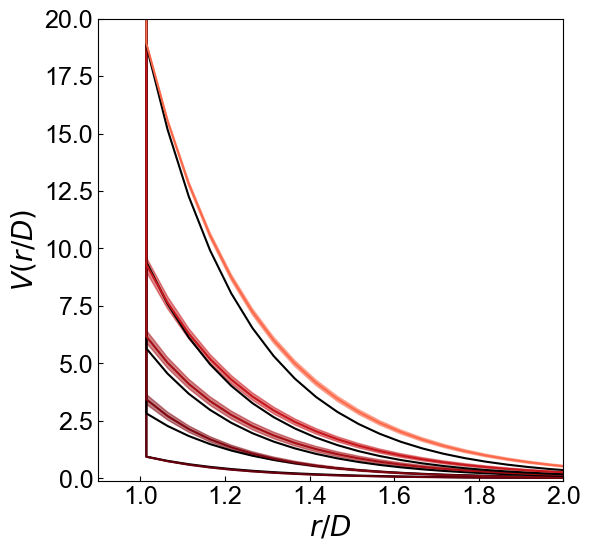

In [34]:
# V(r)
dict_A = loadmat('fp_A_fix.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)

for i in range(len(parameters_list)):
    fp_GT = dict_A['fp_GT_list'][i]
    fp_opt_NN = dict_A['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_A['fp_opt_RMSA_list'][i]
    fp_err_NN = dict_A['fp_err_NN_list'][i]
    fp_err_RMSA = dict_A['fp_err_RMSA_list'][i]
    
    r = (1-(fp_GT[2]-A_list[0])/(A_list[-1]-A_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    ur_GT = sample_potential_GT(fp_GT)
    ur_NN, ur_NN_std = sample_potential(fp_opt_NN,fp_err_NN)
    
    ax.fill_between(rr,ur_NN+ur_NN_std,ur_NN-ur_NN_std,color=c_NN,alpha=0.5)
    ax.plot(rr,ur_GT,'k')
    ax.plot(rr,ur_NN,color=c_NN)

ax.set_xlim(0.9,2.0)
ax.set_ylim(-0.1,20)
ax.set_xlabel(r'$r/D$',fontsize=20)
ax.set_ylabel(r'$V(r/D)$',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18)

plt.show()

## overlapped I(Q)

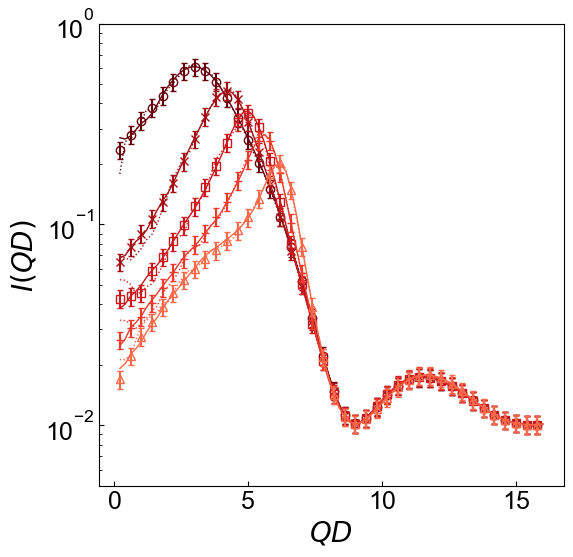

In [35]:
# eta, overlapped
# NN fitting curve and MD invertion
dict_eta = loadmat('fp_eta_fix.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)

for i in range(len(parameters_list)):
    fp_GT = dict_eta['fp_GT_list'][i]
    IQ_exp_GT = dict_eta['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_eta['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_eta['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[0]-eta_list[0])/(eta_list[-1]-eta_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
#     ax.plot(q,IQ_exp_GT*10**i,'-k',lw=2,
#             label='ground truth')
    index_q = np.arange(40)*2
    ax.plot(q,IQ_MD*1**i,
            ':', lw=1, label='NN_MD', color=c_NN)
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*1**i,'-',
            label='NN', color=c_NN, lw=1)
#     ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'-',
#             label='RMSA', color=c_RMSA, lw=3)
    
    ax.plot(q[index_q],IQ_exp_GT[index_q]*1**i,
            markers[i], color=c_NN, fillstyle='none', lw=1, alpha=1,
            label='ground truth')
    ax.errorbar(q[index_q],IQ_exp_GT[index_q]*1**i,IQ_exp_GT[index_q]*1**i*0.1,
            alpha=1,fmt='none',color=c_NN,capsize=2.0)

    ax.set_yscale('log')
    ax.set_ylim([5e-3,1e0])
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=20)
ax.set_ylabel(r'$I(QD)$',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18)

plt.show()

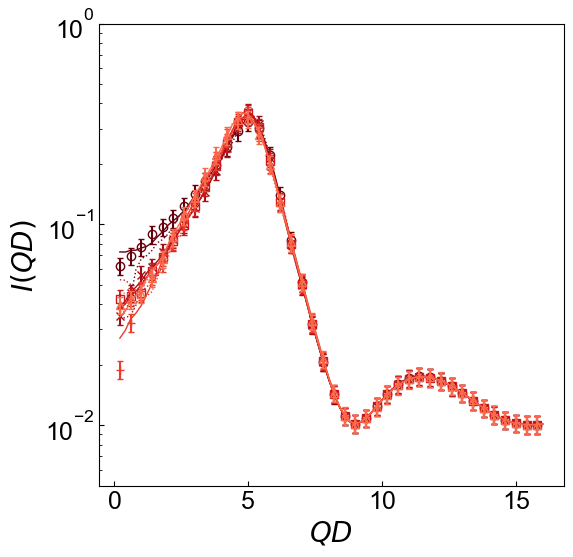

In [72]:
# kappa, overlapped
# NN fitting curve and MD invertion
dict_kappa = loadmat('fp_kappa_fix.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)+5

for i in range(len(parameters_list)):
    fp_GT = dict_kappa['fp_GT_list'][i]
    IQ_exp_GT = dict_kappa['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_kappa['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_kappa['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[1]-kappa_list[0])/(kappa_list[-1]-kappa_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
#     ax.plot(q,IQ_exp_GT*10**i,'-k',lw=2,
#             label='ground truth')
    index_q = np.arange(40)*2
    ax.plot(q,IQ_MD*1**i,
            ':', lw=1, label='NN_MD', color=c_NN)
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*1**i,'-',
            label='NN', color=c_NN, lw=1)
#     ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'-',
#             label='RMSA', color=c_RMSA, lw=3)
    
    ax.plot(q[index_q],IQ_exp_GT[index_q]*1**i,
            markers[i], color=c_NN, fillstyle='none', lw=1, alpha=1,
            label='ground truth')
    ax.errorbar(q[index_q],IQ_exp_GT[index_q]*1**i,IQ_exp_GT[index_q]*1**i*0.1,
            alpha=1,fmt='none',color=c_NN,capsize=2.0)

    ax.set_yscale('log')
    ax.set_ylim([5e-3,1e0])
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=20)
ax.set_ylabel(r'$I(QD)$',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18)

plt.show()

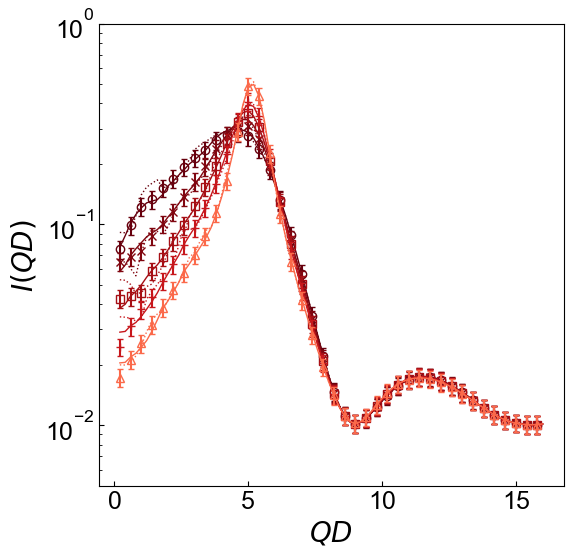

In [37]:
# A, overlapped
# NN fitting curve and MD invertion
dict_A = loadmat('fp_A_fix.mat')

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

index_MD = np.arange(5)+10

for i in range(len(parameters_list)):
    fp_GT = dict_A['fp_GT_list'][i]
    IQ_exp_GT = dict_A['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_A['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_A['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[2]-A_list[0])/(A_list[-1]-A_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
#     ax.plot(q,IQ_exp_GT*10**i,'-k',lw=2,
#             label='ground truth')
    index_q = np.arange(40)*2
    ax.plot(q,IQ_MD*1**i,
            ':', lw=1, label='NN_MD', color=c_NN)
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*1**i,'-',
            label='NN', color=c_NN, lw=1)
#     ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'-',
#             label='RMSA', color=c_RMSA, lw=3)
    
    ax.plot(q[index_q],IQ_exp_GT[index_q]*1**i,
            markers[i], color=c_NN, fillstyle='none', lw=1, alpha=1,
            label='ground truth')
    ax.errorbar(q[index_q],IQ_exp_GT[index_q]*1**i,IQ_exp_GT[index_q]*1**i*0.1,
            alpha=1,fmt='none',color=c_NN,capsize=2.0)

    ax.set_yscale('log')
    ax.set_ylim([5e-3,1e0])
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=20)
ax.set_ylabel(r'$I(QD)$',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18)

plt.show()

## Table

In [44]:
dict_patameter_list = [dict_eta,dict_kappa,dict_A]
def print_table(dict_patameter):
        for i in range(len(parameters_list)):

            fp_GT = dict_patameter['fp_GT_list'][i]
            fp_opt_NN = dict_patameter['fp_opt_NN_list'][i]
            fp_opt_RMSA = dict_patameter['fp_opt_RMSA_list'][i]
            fp_err_NN = dict_patameter['fp_err_NN_list'][i]
            fp_err_RMSA = dict_patameter['fp_err_RMSA_list'][i]

        #     #relative error
        #     fp_NN_err = (fp_opt_NN-fp_GT)/fp_GT
        #     fp_NN_RMSA = (fp_opt_RMSA-fp_GT)/fp_GT

            index_print = [0,1,2]

            string_GT = '{:0.3f} & {:0.3f} & {:0.3f} & '.format(*fp_GT)
            string_NN = ''
            for j in index_print:
                string_NN += '{:0.3f}$\pm${:0.3f}'.format(fp_opt_NN[j],fp_err_NN[j])
                if j<3:
                    string_NN += ' & '
                    
            string_RMSA = ''
            for j in index_print:
                string_RMSA += '{:0.3f}$\pm${:0.3f}'.format(fp_opt_RMSA[j],fp_err_RMSA[j])
                if j<2:
                    string_RMSA += ' & '

            string_row = string_GT+string_NN+string_RMSA+r'\\'
            print(string_row)

In [45]:
dict_patameter_list = [dict_eta,dict_kappa,dict_A]
print(r'\begin{tabular}{ccccccccc}')
print('\hline')
print('\hline')
print(r'$\phi$ & $1/\kappa D$ & $\beta AD$ & $\phi$ & $1/\kappa D$ & $\beta AD$ & $\phi$ & $1/\kappa D$ & $\beta AD$\\')
for i in dict_patameter_list:
    print('\hline')
    print_table(i)
print('\hline')
print('\end{tabular}')

\begin{tabular}{ccccccccc}
\hline
\hline
$\phi$ & $1/\kappa D$ & $\beta AD$ & $\phi$ & $1/\kappa D$ & $\beta AD$ & $\phi$ & $1/\kappa D$ & $\beta AD$\\
\hline
0.045 & 0.300 & 6.000 & 0.045$\pm$0.001 & 0.314$\pm$0.016 & 6.001$\pm$0.010 & 0.045$\pm$0.005 & 0.479$\pm$0.067 & 3.296$\pm$0.879\\
0.135 & 0.300 & 6.000 & 0.138$\pm$0.002 & 0.386$\pm$0.029 & 5.699$\pm$0.142 & 0.132$\pm$0.003 & 0.378$\pm$0.027 & 5.605$\pm$0.481\\
0.225 & 0.300 & 6.000 & 0.225$\pm$0.003 & 0.320$\pm$0.018 & 6.539$\pm$0.281 & 0.222$\pm$0.004 & 0.327$\pm$0.021 & 5.760$\pm$0.288\\
0.315 & 0.300 & 6.000 & 0.314$\pm$0.003 & 0.321$\pm$0.022 & 6.902$\pm$0.141 & 0.316$\pm$0.003 & 0.456$\pm$0.044 & 4.605$\pm$0.228\\
0.405 & 0.300 & 6.000 & 0.407$\pm$0.003 & 0.335$\pm$0.019 & 6.551$\pm$0.204 & 0.387$\pm$0.002 & 0.500$\pm$0.010 & 3.835$\pm$0.204\\
\hline
0.225 & 0.100 & 6.000 & 0.225$\pm$0.003 & 0.125$\pm$0.006 & 6.000$\pm$0.010 & 0.223$\pm$0.010 & 0.176$\pm$0.032 & 4.035$\pm$0.663\\
0.225 & 0.200 & 6.000 & 0.232$\pm$0.002 & 

In [46]:
# Split
dict_patameter_list = [dict_eta,dict_kappa,dict_A]
roman_numerals = ['i','ii','iii','iv','v','vi','vii','viii','ix','x','xi','xii','xiii','xiv','xv']
def print_table_NN(dict_patameter,roman=False,index_dict=0):
        for i in range(len(parameters_list)):

            fp_GT = dict_patameter['fp_GT_list'][i]
            fp_opt_NN = dict_patameter['fp_opt_NN_list'][i]
            fp_opt_RMSA = dict_patameter['fp_opt_RMSA_list'][i]
            fp_err_NN = dict_patameter['fp_err_NN_list'][i]
            fp_err_RMSA = dict_patameter['fp_err_RMSA_list'][i]

        #     #relative error
        #     fp_NN_err = (fp_opt_NN-fp_GT)/fp_GT
        #     fp_NN_RMSA = (fp_opt_RMSA-fp_GT)/fp_GT

            index_print = [0,1,2,6]

            string_GT = '{:0.3f} & {:0.3f} & {:0.3f} & {:0.3f} & '.format(*fp_GT[index_print])
            string_NN = ''
            for j in index_print:
                fp_GT_j = fp_GT[j]
                string_NN += '{:0.3f}$\pm${:0.3f}'.format(fp_opt_NN[j]/fp_GT_j,fp_err_NN[j]/fp_GT_j)
                if j<3:
                    string_NN += ' & '

            string_row = string_GT+string_NN+r'\\'
            
            if roman:
                string_row = roman_numerals[i+index_dict*len(parameters_list)] + ' & ' + string_row
            print(string_row)
            
def print_table_RMSA(dict_patameter,roman=False,index_dict=0):
        for i in range(len(parameters_list)):

            fp_GT = dict_patameter['fp_GT_list'][i]
            fp_opt_NN = dict_patameter['fp_opt_NN_list'][i]
            fp_opt_RMSA = dict_patameter['fp_opt_RMSA_list'][i]
            fp_err_NN = dict_patameter['fp_err_NN_list'][i]
            fp_err_RMSA = dict_patameter['fp_err_RMSA_list'][i]

        #     #relative error
        #     fp_NN_err = (fp_opt_NN-fp_GT)/fp_GT
        #     fp_NN_RMSA = (fp_opt_RMSA-fp_GT)/fp_GT

            index_print = [0,1,2,6]

            string_GT = '{:0.3f} & {:0.3f} & {:0.3f} & {:0.3f} & '.format(*fp_GT[index_print])
            string_RMSA = ''
            for j in index_print:
                fp_GT_j = fp_GT[j]
                string_RMSA += '{:0.3f}$\pm${:0.3f}'.format(fp_opt_RMSA[j]/fp_GT_j,fp_err_RMSA[j]/fp_GT_j)
                if j<3:
                    string_RMSA += ' & '

            string_row = string_GT+string_RMSA+r'\\'
            
            if roman:
                string_row = roman_numerals[i+index_dict*len(parameters_list)] + ' & ' + string_row
            print(string_row)

In [47]:
dict_patameter_list = [dict_eta,dict_kappa,dict_A]
print(r'\resizebox{\textwidth}{!}{%')
print(r'\centering')
print(r'\begin{tabular}{ccccc@{\hspace{1.0cm}}cccc}')
print('\hline')
print('\hline')
print(r' & \multicolumn{4}{c}{GT} & \multicolumn{4}{c}{NN}\\')
print('\hline')
# print(r' & $\phi$ & $1/\kappa D$ & $\beta AD$ & $Z$ & $\phi$ & $1/\kappa D$ & $\beta AD$ & $Z$\\')
print(r' & $\hat{\phi}$ & $1/\hat{\kappa} D$ & $\beta \hat{A}D$ & $\hat{Z}$ &'+
      r' $\phi/\hat{\phi}$ & $\hat{\kappa}/\kappa$ & $A/\hat{A}$ & $Z/\hat{Z}$\\')
for index_dict, i in enumerate(dict_patameter_list):
    print('\hline')
    print_table_NN(i,roman=1,index_dict=index_dict)
print('\hline')
print('\end{tabular}')
print('}')

\resizebox{\textwidth}{!}{%
\centering
\begin{tabular}{ccccc@{\hspace{1.0cm}}cccc}
\hline
\hline
 & \multicolumn{4}{c}{GT} & \multicolumn{4}{c}{NN}\\
\hline
 & $\hat{\phi}$ & $1/\hat{\kappa} D$ & $\beta \hat{A}D$ & $\hat{Z}$ & $\phi/\hat{\phi}$ & $\hat{\kappa}/\kappa$ & $A/\hat{A}$ & $Z/\hat{Z}$\\
\hline
i & 0.045 & 0.300 & 6.000 & 6.532 & 1.005$\pm$0.021 & 1.046$\pm$0.052 & 1.000$\pm$0.002 & 0.972$\pm$0.030\\
ii & 0.135 & 0.300 & 6.000 & 6.532 & 1.023$\pm$0.014 & 1.288$\pm$0.095 & 0.950$\pm$0.024 & 0.839$\pm$0.036\\
iii & 0.225 & 0.300 & 6.000 & 6.532 & 0.999$\pm$0.014 & 1.067$\pm$0.061 & 1.090$\pm$0.047 & 1.003$\pm$0.041\\
iv & 0.315 & 0.300 & 6.000 & 6.532 & 0.997$\pm$0.011 & 1.072$\pm$0.072 & 1.150$\pm$0.024 & 1.028$\pm$0.043\\
v & 0.405 & 0.300 & 6.000 & 6.532 & 1.004$\pm$0.008 & 1.115$\pm$0.065 & 1.092$\pm$0.034 & 0.977$\pm$0.037\\
\hline
vi & 0.225 & 0.100 & 6.000 & 14.697 & 0.999$\pm$0.011 & 1.253$\pm$0.060 & 1.000$\pm$0.002 & 0.832$\pm$0.032\\
vii & 0.225 & 0.200 & 6.000 & 8.5

In [48]:
dict_patameter_list = [dict_eta,dict_kappa,dict_A]
print(r'\resizebox{\textwidth}{!}{%')
print(r'\centering')
print(r'\begin{tabular}{ccccc@{\hspace{1.0cm}}cccc}')
print('\hline')
print('\hline')
print(r' & \multicolumn{4}{c}{GT} & \multicolumn{4}{c}{RMSA}\\')
print('\hline')
# print(r' & $\phi$ & $1/\kappa D$ & $\beta AD$ & $Z$ & $\phi$ & $1/\kappa D$ & $\beta AD$ & $Z$\\')
print(r' & $\hat{\phi}$ & $1/\hat{\kappa} D$ & $\beta \hat{A}D$ & $\hat{Z}$ &'+
      r' $\phi/\hat{\phi}$ & $\hat{\kappa}/\kappa$ & $A/\hat{A}$ & $Z/\hat{Z}$\\')
for index_dict, i in enumerate(dict_patameter_list):
    print('\hline')
    print_table_RMSA(i,roman=1,index_dict=index_dict)
print('\hline')
print('\end{tabular}')
print('}')

\resizebox{\textwidth}{!}{%
\centering
\begin{tabular}{ccccc@{\hspace{1.0cm}}cccc}
\hline
\hline
 & \multicolumn{4}{c}{GT} & \multicolumn{4}{c}{RMSA}\\
\hline
 & $\hat{\phi}$ & $1/\hat{\kappa} D$ & $\beta \hat{A}D$ & $\hat{Z}$ & $\phi/\hat{\phi}$ & $\hat{\kappa}/\kappa$ & $A/\hat{A}$ & $Z/\hat{Z}$\\
\hline
i & 0.045 & 0.300 & 6.000 & 6.532 & 0.994$\pm$0.107 & 1.598$\pm$0.224 & 0.549$\pm$0.147 & 0.568$\pm$0.086\\
ii & 0.135 & 0.300 & 6.000 & 6.532 & 0.976$\pm$0.026 & 1.260$\pm$0.092 & 0.934$\pm$0.080 & 0.842$\pm$0.050\\
iii & 0.225 & 0.300 & 6.000 & 6.532 & 0.988$\pm$0.018 & 1.088$\pm$0.069 & 0.960$\pm$0.048 & 0.930$\pm$0.043\\
iv & 0.315 & 0.300 & 6.000 & 6.532 & 1.004$\pm$0.010 & 1.520$\pm$0.147 & 0.767$\pm$0.038 & 0.689$\pm$0.039\\
v & 0.405 & 0.300 & 6.000 & 6.532 & 0.956$\pm$0.005 & 1.667$\pm$0.033 & 0.639$\pm$0.034 & 0.600$\pm$0.017\\
\hline
vi & 0.225 & 0.100 & 6.000 & 14.697 & 0.990$\pm$0.045 & 1.760$\pm$0.324 & 0.673$\pm$0.111 & 0.525$\pm$0.083\\
vii & 0.225 & 0.200 & 6.000 & 8

In [49]:
dict_eta_SQ = loadmat('fp_eta_SQ.mat')
dict_kappa_SQ = loadmat('fp_kappa_SQ.mat')
dict_A_SQ = loadmat('fp_A_SQ.mat')
dict_patameter_list = [dict_eta_SQ,dict_kappa_SQ,dict_A_SQ]
print(r'\resizebox{\textwidth}{!}{%')
print(r'\centering')
print(r'\begin{tabular}{ccccc@{\hspace{1.0cm}}cccc}')
print('\hline')
print('\hline')
print(r' & \multicolumn{4}{c}{GT} & \multicolumn{4}{c}{NN}\\')
print('\hline')
# print(r' & $\phi$ & $1/\kappa D$ & $\beta AD$ & $Z$ & $\phi$ & $1/\kappa D$ & $\beta AD$ & $Z$\\')
print(r' & $\hat{\phi}$ & $1/\hat{\kappa} D$ & $\beta \hat{A}D$ & $\hat{Z}$ &'+
      r' $\phi/\hat{\phi}$ & $\hat{\kappa}/\kappa$ & $A/\hat{A}$ & $Z/\hat{Z}$\\')
for index_dict, i in enumerate(dict_patameter_list):
    print('\hline')
    print_table_NN(i,roman=1,index_dict=index_dict)
print('\hline')
print('\end{tabular}')
print('}')

\resizebox{\textwidth}{!}{%
\centering
\begin{tabular}{ccccc@{\hspace{1.0cm}}cccc}
\hline
\hline
 & \multicolumn{4}{c}{GT} & \multicolumn{4}{c}{NN}\\
\hline
 & $\hat{\phi}$ & $1/\hat{\kappa} D$ & $\beta \hat{A}D$ & $\hat{Z}$ & $\phi/\hat{\phi}$ & $\hat{\kappa}/\kappa$ & $A/\hat{A}$ & $Z/\hat{Z}$\\
\hline
i & 0.045 & 0.300 & 6.000 & 6.532 & 1.019$\pm$0.048 & 1.005$\pm$0.030 & 1.000$\pm$0.002 & 0.997$\pm$0.018\\
ii & 0.135 & 0.300 & 6.000 & 6.532 & 0.983$\pm$0.046 & 0.950$\pm$0.043 & 1.000$\pm$0.002 & 1.033$\pm$0.030\\
iii & 0.225 & 0.300 & 6.000 & 6.532 & 1.002$\pm$0.018 & 0.989$\pm$0.086 & 1.000$\pm$0.002 & 1.007$\pm$0.055\\
iv & 0.315 & 0.300 & 6.000 & 6.532 & 0.996$\pm$0.008 & 0.947$\pm$0.016 & 1.000$\pm$0.001 & 1.035$\pm$0.011\\
v & 0.405 & 0.300 & 6.000 & 6.532 & 0.996$\pm$0.005 & 0.990$\pm$0.022 & 1.000$\pm$0.002 & 1.006$\pm$0.014\\
\hline
vi & 0.225 & 0.100 & 6.000 & 14.697 & 1.017$\pm$0.009 & 1.268$\pm$0.022 & 0.913$\pm$0.013 & 0.787$\pm$0.012\\
vii & 0.225 & 0.200 & 6.000 & 8.5

## Worst cases

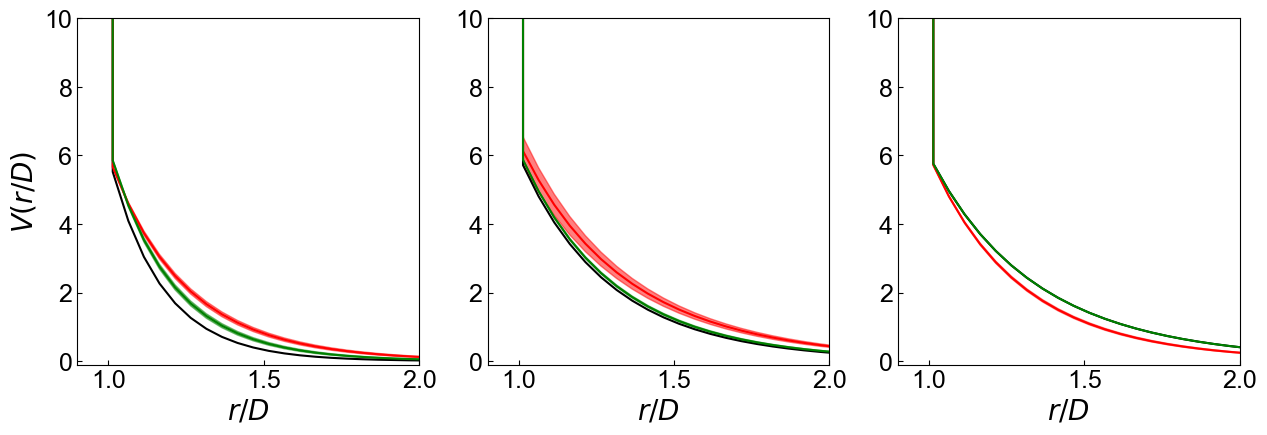

In [44]:
# V(r)
dict_kappa = loadmat('fp_kappa_fix.mat')
dict_kappa_SQ = loadmat('fp_kappa_SQ.mat')

fig = plt.figure(figsize=(15, 4.5))#,dpi=192)

index_MD = np.arange(5)

for i_id, i in enumerate([1,3,4]):
    ax = plt.subplot(1, 3, i_id+1)
    fp_GT = dict_kappa['fp_GT_list'][i]
    fp_opt_NN = dict_kappa['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_kappa['fp_opt_RMSA_list'][i]
    fp_err_NN = dict_kappa['fp_err_NN_list'][i]
    fp_err_RMSA = dict_kappa['fp_err_RMSA_list'][i]
    
    fp_opt_NN_SQ = dict_kappa_SQ['fp_opt_NN_list'][i]
    fp_opt_RMSA_SQ = dict_kappa_SQ['fp_opt_RMSA_list'][i]
    fp_err_NN_SQ = dict_kappa_SQ['fp_err_NN_list'][i]
    fp_err_RMSA_SQ = dict_kappa_SQ['fp_err_RMSA_list'][i]
    
    r = (1-(fp_GT[1]-kappa_list[0])/(kappa_list[-1]-kappa_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    ur_GT = sample_potential_GT(fp_GT)
    ur_NN, ur_NN_std = sample_potential(fp_opt_NN,fp_err_NN)
    ur_RMSA, ur_RMSA_std = sample_potential(fp_opt_RMSA,fp_err_RMSA)
    
    ur_NN_SQ, ur_NN_SQ_std = sample_potential(fp_opt_NN_SQ,fp_err_NN_SQ)
    ur_RMSA_SQ, ur_RMSA_SQ_std = sample_potential(fp_opt_RMSA_SQ,fp_err_RMSA_SQ)
    
    # V(r) from NN
    ax.fill_between(rr,ur_NN+ur_NN_std,ur_NN-ur_NN_std,color='r',alpha=0.5)
    ax.plot(rr,ur_GT,'k')
    ax.plot(rr,ur_NN,color='r')
    
#     # V(r) from RMSA
#     ax.fill_between(rr,ur_RMSA+ur_RMSA_std,ur_RMSA-ur_RMSA_std,color='b',alpha=0.5)
# #     ax.plot(rr,ur_GT,'k')
#     ax.plot(rr,ur_RMSA,color='b')

    # V(r) from NN, SQ fitting
    ax.fill_between(rr,ur_NN_SQ+ur_NN_SQ_std,ur_NN_SQ-ur_NN_SQ_std,color='g',alpha=0.5)
    ax.plot(rr,ur_NN_SQ,color='g')
    
#     ax.set_yscale('log')
    ax.set_xlim(0.9,2.0)
    ax.set_ylim(-0.1,10)
    ax.set_xlabel(r'$r/D$',fontsize=20)
#     ax.set_ylabel(r'$V(r/D)$',fontsize=20)
    ax.tick_params(direction='in', axis='both', which='both', labelsize=18)
    
    if i_id==0:
        ax.set_ylabel(r'$V(r/D)$',fontsize=20)

plt.show()

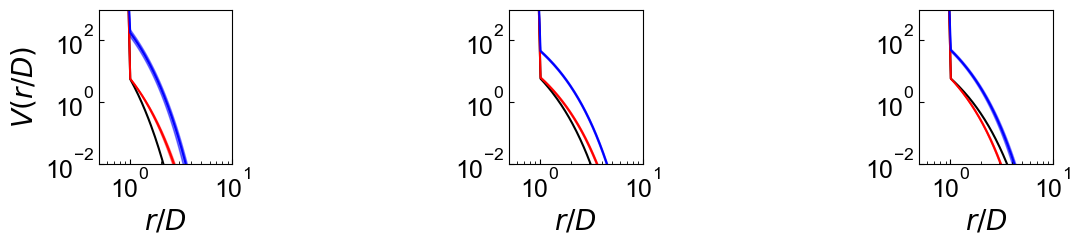

In [45]:
# V(r) in logscale
dict_kappa = loadmat('fp_kappa_fix.mat')

fig = plt.figure(figsize=(15, 2))#,dpi=192)

index_MD = np.arange(5)

for i_id, i in enumerate([1,3,4]):
    ax = plt.subplot(1, 3, i_id+1)
    fp_GT = dict_kappa['fp_GT_list'][i]
    fp_opt_NN = dict_kappa['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_kappa['fp_opt_RMSA_list'][i]
    fp_err_NN = dict_kappa['fp_err_NN_list'][i]
    fp_err_RMSA = dict_kappa['fp_err_RMSA_list'][i]
    
    r = (1-(fp_GT[1]-kappa_list[0])/(kappa_list[-1]-kappa_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    ur_GT = sample_potential_GT(fp_GT)
    ur_NN, ur_NN_std = sample_potential(fp_opt_NN,fp_err_NN)
    ur_RMSA, ur_RMSA_std = sample_potential(fp_opt_RMSA,fp_err_RMSA)
    
    # V(r) from NN
    ax.fill_between(rr,ur_NN+ur_NN_std,ur_NN-ur_NN_std,color='r',alpha=0.5)
    ax.plot(rr,ur_GT,'k')
    ax.plot(rr,ur_NN,color='r')
    
    # V(r) from RMSA
    ax.fill_between(rr,ur_RMSA+ur_RMSA_std,ur_RMSA-ur_RMSA_std,color='b',alpha=0.5)
#     ax.plot(rr,ur_GT,'k')
    ax.plot(rr,ur_RMSA,color='b')
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(0.5,10)
    ax.set_ylim(0.01,1000)
    ax.set_xlabel(r'$r/D$',fontsize=20)
#     ax.set_ylabel(r'$V(r/D)$',fontsize=20)
    ax.tick_params(direction='in', axis='both', which='both', labelsize=18)
    
    if i_id==0:
        ax.set_ylabel(r'$V(r/D)$',fontsize=20)
        
    ax.set_aspect(0.3)

plt.show()

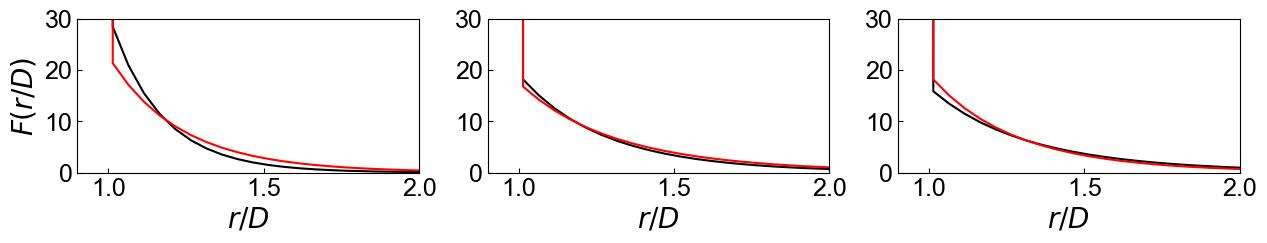

In [46]:
# Force
dict_kappa = loadmat('fp_kappa_fix.mat')

fig = plt.figure(figsize=(15, 2))#,dpi=192)

index_MD = np.arange(5)

for i_id, i in enumerate([1,3,4]):
    ax = plt.subplot(1, 3, i_id+1)
    fp_GT = dict_kappa['fp_GT_list'][i]
    fp_opt_NN = dict_kappa['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_kappa['fp_opt_RMSA_list'][i]
    fp_err_NN = dict_kappa['fp_err_NN_list'][i]
    fp_err_RMSA = dict_kappa['fp_err_RMSA_list'][i]
    
    r = (1-(fp_GT[1]-kappa_list[0])/(kappa_list[-1]-kappa_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    ur_GT = sample_potential_GT(fp_GT)
    ur_NN, ur_NN_std = sample_potential(fp_opt_NN,fp_err_NN)
    ur_RMSA, ur_RMSA_std = sample_potential(fp_opt_RMSA,fp_err_RMSA)
    
    dr = rr[1] - rr[0]
    d_ur_GT = -np.diff(ur_GT)/dr
    d_ur_NN = -np.diff(ur_NN)/dr
    
    # V(r) from NN
#     ax.fill_between(rr,ur_NN+ur_NN_std,ur_NN-ur_NN_std,color='r',alpha=0.5)
#     ax.plot(rr,ur_GT,'k')
#     ax.plot(rr,ur_NN,color='r')
    
    ax.plot(rr[0:199],d_ur_GT,'k')
    ax.plot(rr[0:199],d_ur_NN,color='r')
    
    # V(r) from RMSA
#     ax.fill_between(rr,ur_RMSA+ur_RMSA_std,ur_RMSA-ur_RMSA_std,color='b',alpha=0.5)
#     ax.plot(rr,ur_GT,'k')
#     ax.plot(rr,ur_RMSA,color='b')
    
#     ax.set_yscale('log')
#     ax.set_xscale('log')
    ax.set_xlim(0.9,2)
    ax.set_ylim(0,30)
    ax.set_xlabel(r'$r/D$',fontsize=20)
#     ax.set_ylabel(r'$V(r/D)$',fontsize=20)
    ax.tick_params(direction='in', axis='both', which='both', labelsize=18)
    
    if i_id==0:
        ax.set_ylabel(r'$F(r/D)$',fontsize=20)
        
#     ax.set_aspect(0.28)

plt.show()

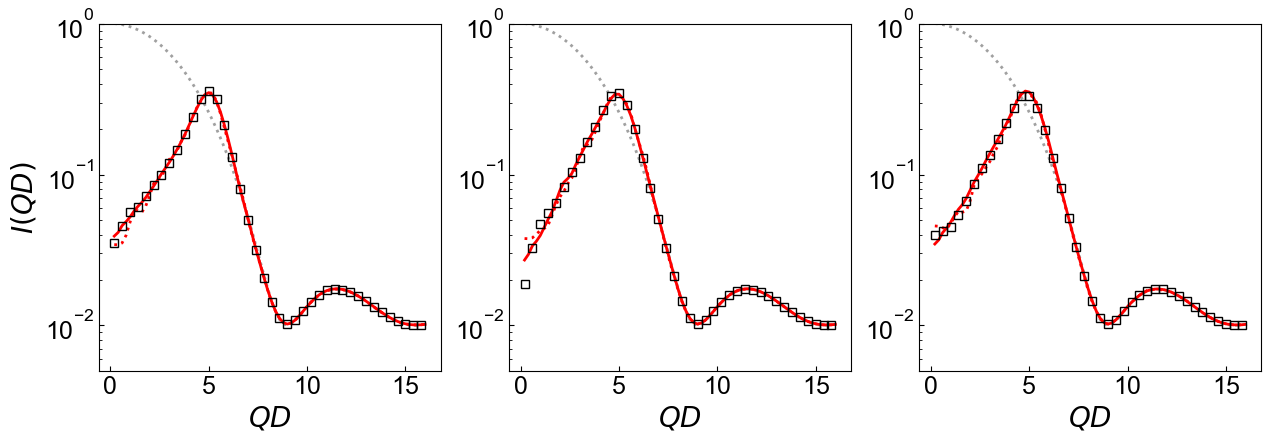

In [47]:
# kappa, overlapped
# NN fitting curve and MD invertion
dict_kappa = loadmat('fp_kappa_fix.mat')

fig = plt.figure(figsize=(15, 4.5))#,dpi=192)

index_MD = np.arange(5)+5

for i_id, i in enumerate([1,3,4]):
    ax = plt.subplot(1, 3, i_id+1)
    fp_GT = dict_kappa['fp_GT_list'][i]
    IQ_exp_GT = dict_kappa['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_kappa['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_kappa['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[1]-kappa_list[0])/(kappa_list[-1]-kappa_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
    ## P(Q)
    ax.plot(q,hardsphere(q)*1**i+0.01,
            ':', lw=2, label='NN_MD', color='#A0A0A0')

    ## MD
#     ax.plot(q,IQ_exp_GT*10**i,'-k',lw=2,
#             label='ground truth')
    index_q = np.arange(40)*2
    ax.plot(q,IQ_MD*1**i,
            ':', lw=2, label='NN_MD', color='r')
    
    ## fitting
#     ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*1**i,'-',
#             label='NN', color='b', lw=2) # RMSA
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*1**i,'-',
            label='NN', color='r', lw=2)
    
#     ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'-',
#             label='RMSA', color=c_RMSA, lw=3)
    
    ## GT
    ax.plot(q[index_q],IQ_exp_GT[index_q]*1**i,
            's', color='k', fillstyle='none', lw=1, alpha=1,
            label='ground truth')
#     ax.errorbar(q[index_q],IQ_exp_GT[index_q]*1**i,IQ_exp_GT[index_q]*1**i*0.1,
#             alpha=1,fmt='none',color='k',capsize=2.0)


    ax.set_yscale('log')
    ax.set_ylim([5e-3,1e0])
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

    ax.set_xlabel(r'$QD$',fontsize=20)
#     ax.set_ylabel(r'$I(QD)$',fontsize=20)
    ax.tick_params(direction='in', axis='both', which='both', labelsize=18)
    
    if i_id==0:
        ax.set_ylabel(r'$I(QD)$',fontsize=20)


plt.show()

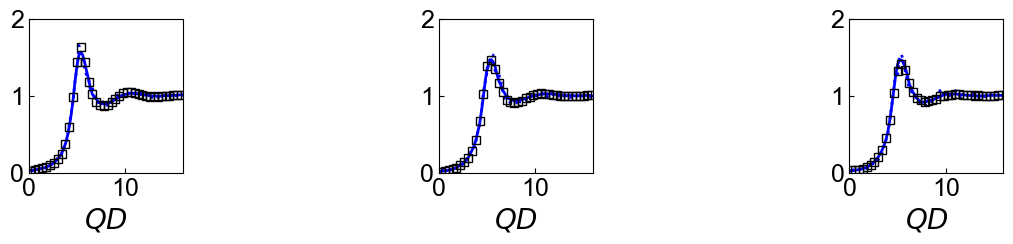

In [48]:
# kappa, overlapped
# NN fitting curve and MD invertion
dict_kappa = loadmat('fp_kappa_fix.mat')

fig = plt.figure(figsize=(15, 2))#,dpi=192)

index_MD = np.arange(5)+5

for i_id, i in enumerate([1,3,4]):
    ax = plt.subplot(1, 3, i_id+1)
    fp_GT = dict_kappa['fp_GT_list'][i]
    IQ_exp_GT = dict_kappa['IQ_exp_GT_list'][i]
    SQ_exp_GT = dict_kappa['SQ_exp_GT_list'][i]
    fp_opt_NN = dict_kappa['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_kappa['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[1]-kappa_list[0])/(kappa_list[-1]-kappa_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = load_SQ_MD(filename)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
#     ax.plot(q,IQ_exp_GT*10**i,'-k',lw=2,
#             label='ground truth')
    index_q = np.arange(40)*2
    ax.plot(q,SQ_MD*1**i,
            ':', lw=2, label='NN_MD', color='b')
#     ax.plot(q,SQ_RMSA(fp_opt_RMSA)*1**i,'-',
#             label='NN', color='b', lw=2) # RMSA
    ax.plot(q,SQ_NN(fp_opt_NN)*1**i,'-',
            label='NN', color='b', lw=2)
#     ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'-',
#             label='RMSA', color=c_RMSA, lw=3)
    
    ax.plot(q[index_q],SQ_exp_GT[index_q]*1**i,
            's', color='k', fillstyle='none', lw=1, alpha=1,
            label='ground truth')
#     ax.errorbar(q[index_q],SQ_exp_GT[index_q]*1**i,SQ_exp_GT[index_q]*1**i*0.1,
#             alpha=1,fmt='none',color='k',capsize=2.0)

#     ax.set_yscale('log')
    ax.set_ylim([0,2])
    ax.set_xlim([0,16])
    ax.set_yticks([0,1,2])
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

    ax.set_xlabel(r'$QD$',fontsize=20)
#     ax.set_ylabel(r'$I(QD)$',fontsize=20)
    ax.tick_params(direction='in', axis='both', which='both', labelsize=18)
    ax.set_aspect(8)

plt.show()

## Residue

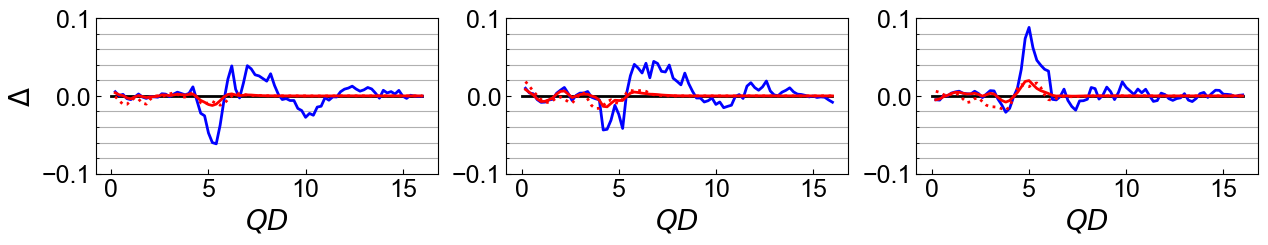

In [49]:
# kappa, overlapped
# NN fitting curve and MD invertion
# Residue
dict_kappa = loadmat('fp_kappa_fix.mat')

fig = plt.figure(figsize=(15, 2.5))#,dpi=192)

index_MD = np.arange(5)+5

for i_id, i in enumerate([1,3,4]):
    ax = plt.subplot(1, 3, i_id+1)
    fp_GT = dict_kappa['fp_GT_list'][i]
    IQ_exp_GT = dict_kappa['IQ_exp_GT_list'][i]
    SQ_exp_GT = dict_kappa['SQ_exp_GT_list'][i]
    fp_opt_NN = dict_kappa['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_kappa['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[1]-kappa_list[0])/(kappa_list[-1]-kappa_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = sm_GP(load_SQ_MD(filename),lmbda=0.5, sigma=0.1)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
    index_q = np.arange(40)*2
    ax.plot([0,16],[0,0],'-', color='k', lw=2) # baseline
    
    # S(Q)
#     ax.plot(q,(SQ_MD-SQ_exp_GT)*1**i,
#             ':', lw=2, label='NN_MD', color='b') # MD reconstructed
#     ax.plot(q,(IQ_th(SQ_RMSA,fp_opt_RMSA)-IQ_exp_GT)*1**i,'-',
#             label='NN', color='b', lw=2) # RMSA model fit
    ax.plot(q,(SQ_NN(fp_opt_NN)-SQ_exp_GT)*1**i,'-',
            label='NN', color='b', lw=2) # NN model fit
    
    # I(Q)
    ax.plot(q,(IQ_MD-IQ_exp_GT)*1**i,
            ':', lw=2, label='NN_MD', color='r') # MD reconstructed
#     ax.plot(q,(IQ_th(SQ_RMSA,fp_opt_RMSA)-IQ_exp_GT)*1**i,'-',
#             label='NN', color='b', lw=2) # RMSA model fit
    ax.plot(q,(IQ_th(SQ_NN,fp_opt_NN)-IQ_exp_GT)*1**i,'-',
            label='NN', color='r', lw=2) # NN model fit
    
    
    
#     ax.plot(q[index_q],IQ_exp_GT[index_q]*1**i,
#             's', color='k', fillstyle='none', lw=1, alpha=1,
#             label='ground truth')
#     ax.errorbar(q[index_q],IQ_exp_GT[index_q]*1**i,IQ_exp_GT[index_q]*1**i*0.1,
#             alpha=1,fmt='none',color='k',capsize=2.0)

#     ax.set_yscale('log')
    ax.set_ylim([-1e-1,1e-1])
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

    ax.set_xlabel(r'$QD$',fontsize=20)
#     ax.set_ylabel(r'$I(QD)$',fontsize=20)
    ax.tick_params(direction='in', axis='both', which='both', labelsize=18)
    
    if i_id==0:
        ax.set_ylabel(r'$\Delta$',fontsize=20)
        
    ax.set_aspect(40)
    ax.set_yticks(np.linspace(-0.1,0.1,11), minor=True)
    ax.grid(visible=True, which='minor', axis='y')


plt.show()

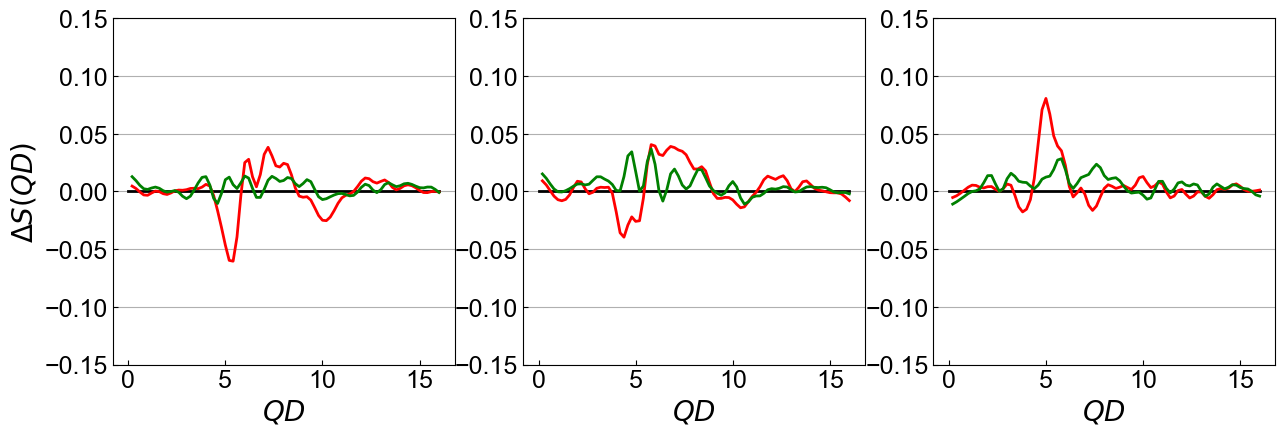

In [50]:
# kappa, overlapped
# NN fitting curve and MD invertion
# Residue
dict_kappa = loadmat('fp_kappa_fix.mat')
dict_kappa_SQ = loadmat('fp_kappa_SQ.mat')

fig = plt.figure(figsize=(15, 4.5))#,dpi=192)

index_MD = np.arange(5)+5

for i_id, i in enumerate([1,3,4]):
    ax = plt.subplot(1, 3, i_id+1)
    fp_GT = dict_kappa['fp_GT_list'][i]
    IQ_exp_GT = dict_kappa['IQ_exp_GT_list'][i]
    SQ_exp_GT = dict_kappa['SQ_exp_GT_list'][i]
    fp_opt_NN = dict_kappa['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_kappa['fp_opt_RMSA_list'][i]
    fp_err_NN = dict_kappa['fp_err_NN_list'][i]
    fp_err_RMSA = dict_kappa['fp_err_RMSA_list'][i]
    
    IQ_exp_GT_SQ = dict_kappa_SQ['IQ_exp_GT_list'][i]
    SQ_exp_GT_SQ = dict_kappa_SQ['SQ_exp_GT_list'][i]
    fp_opt_NN_SQ = dict_kappa_SQ['fp_opt_NN_list'][i]
    fp_opt_RMSA_SQ = dict_kappa_SQ['fp_opt_RMSA_list'][i]
    fp_err_NN_SQ = dict_kappa_SQ['fp_err_NN_list'][i]
    fp_err_RMSA_SQ = dict_kappa_SQ['fp_err_RMSA_list'][i]
    
    r = (1-(fp_GT[1]-kappa_list[0])/(kappa_list[-1]-kappa_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = sm_GP(load_SQ_MD(filename),lmbda=0.5, sigma=0.1)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
    index_q = np.arange(40)*2
    ax.plot([0,16],[0,0],'-', color='k', lw=2) # baseline
    
    # S(Q)
#     ax.plot(q,(SQ_MD-SQ_exp_GT)*1**i,
#             ':', lw=2, label='NN_MD', color='b') # MD reconstructed
#     ax.plot(q,(IQ_th(SQ_RMSA,fp_opt_RMSA)-IQ_exp_GT)*1**i,'-',
#             label='NN', color='b', lw=2) # RMSA model fit
    ax.plot(q,(sm_GP(SQ_NN(fp_opt_NN),lmbda=0.5, sigma=0.1)-sm_GP(SQ_exp_GT,lmbda=0.5, sigma=0.1))*1**i,'-',
            label='NN', color='r', lw=2) # NN model fit
    ax.plot(q,(sm_GP(SQ_NN(fp_opt_NN_SQ),lmbda=0.5, sigma=0.1)-sm_GP(SQ_exp_GT_SQ,lmbda=0.5, sigma=0.1))*1**i,'-',
            label='NN', color='g', lw=2) # NN model fit
    
#     # I(Q)
#     ax.plot(q,(IQ_MD-IQ_exp_GT)*1**i,
#             ':', lw=2, label='NN_MD', color='r') # MD reconstructed
# #     ax.plot(q,(IQ_th(SQ_RMSA,fp_opt_RMSA)-IQ_exp_GT)*1**i,'-',
# #             label='NN', color='b', lw=2) # RMSA model fit
#     ax.plot(q,(IQ_th(SQ_NN,fp_opt_NN)-IQ_exp_GT)*1**i,'-',
#             label='NN', color='r', lw=2) # NN model fit
    
    
    
#     ax.plot(q[index_q],IQ_exp_GT[index_q]*1**i,
#             's', color='k', fillstyle='none', lw=1, alpha=1,
#             label='ground truth')
#     ax.errorbar(q[index_q],IQ_exp_GT[index_q]*1**i,IQ_exp_GT[index_q]*1**i*0.1,
#             alpha=1,fmt='none',color='k',capsize=2.0)

#     ax.set_yscale('log')
    ax.set_ylim([-1e-1,1e-1])
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

    ax.set_xlabel(r'$QD$',fontsize=20)
#     ax.set_ylabel(r'$I(QD)$',fontsize=20)
    ax.tick_params(direction='in', axis='both', which='both', labelsize=18)
    
    if i_id==0:
        ax.set_ylabel(r'$\Delta S(QD)$',fontsize=20)
        
#     ax.set_aspect(80)
    ax.set_yticks(np.linspace(-0.15,0.15,7))
    ax.grid(visible=True, which='both', axis='y')


plt.show()

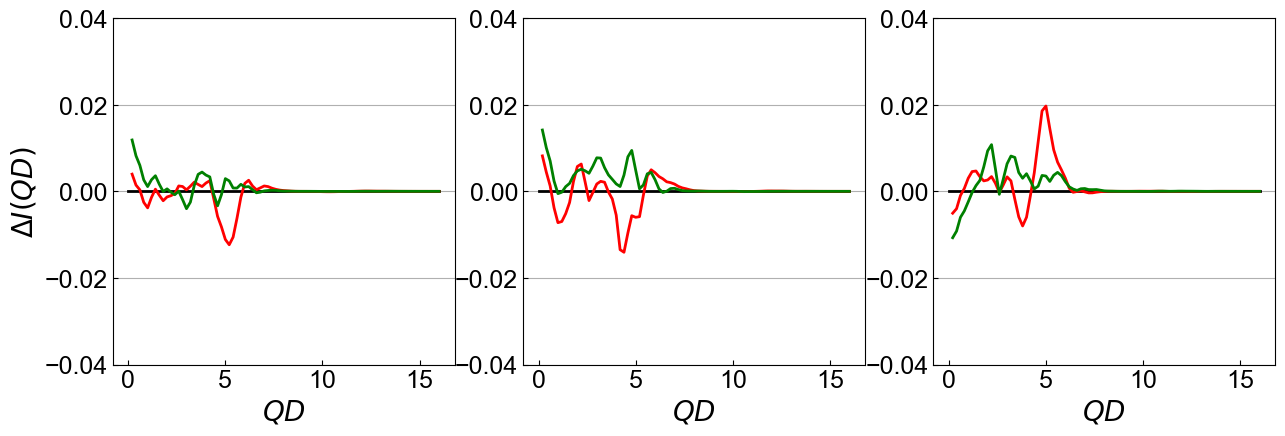

In [51]:
# kappa, overlapped
# NN fitting curve and MD invertion
# Residue
dict_kappa = loadmat('fp_kappa_fix.mat')
dict_kappa_SQ = loadmat('fp_kappa_SQ.mat')

fig = plt.figure(figsize=(15, 4.5))#,dpi=192)

index_MD = np.arange(5)+5

for i_id, i in enumerate([1,3,4]):
    ax = plt.subplot(1, 3, i_id+1)
    fp_GT = dict_kappa['fp_GT_list'][i]
    IQ_exp_GT = dict_kappa['IQ_exp_GT_list'][i]
    SQ_exp_GT = dict_kappa['SQ_exp_GT_list'][i]
    fp_opt_NN = dict_kappa['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_kappa['fp_opt_RMSA_list'][i]
    fp_err_NN = dict_kappa['fp_err_NN_list'][i]
    fp_err_RMSA = dict_kappa['fp_err_RMSA_list'][i]
    
    IQ_exp_GT_SQ = dict_kappa_SQ['IQ_exp_GT_list'][i]
    SQ_exp_GT_SQ = dict_kappa_SQ['SQ_exp_GT_list'][i]
    fp_opt_NN_SQ = dict_kappa_SQ['fp_opt_NN_list'][i]
    fp_opt_RMSA_SQ = dict_kappa_SQ['fp_opt_RMSA_list'][i]
    fp_err_NN_SQ = dict_kappa_SQ['fp_err_NN_list'][i]
    fp_err_RMSA_SQ = dict_kappa_SQ['fp_err_RMSA_list'][i]
    
    r = (1-(fp_GT[1]-kappa_list[0])/(kappa_list[-1]-kappa_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    index_MD_i = index_MD[i]
    filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
    SQ_MD = sm_GP(load_SQ_MD(filename),lmbda=0.5, sigma=0.1)
    IQ_MD = IQ_exp(SQ_MD,fp_GT)
    
    index_q = np.arange(40)*2
    ax.plot([0,16],[0,0],'-', color='k', lw=2) # baseline
    
    # S(Q)
#     ax.plot(q,(SQ_MD-SQ_exp_GT)*1**i,
#             ':', lw=2, label='NN_MD', color='b') # MD reconstructed
#     ax.plot(q,(IQ_th(SQ_RMSA,fp_opt_RMSA)-IQ_exp_GT)*1**i,'-',
#             label='NN', color='b', lw=2) # RMSA model fit
#     ax.plot(q,(SQ_NN(fp_opt_NN)-SQ_exp_GT)*1**i,'-',
#             label='NN', color='r', lw=2) # NN model fit
#     ax.plot(q,(SQ_NN(fp_opt_NN_SQ)-SQ_exp_GT)*1**i,'-',
#             label='NN', color='b', lw=2) # NN model fit
    
    # I(Q)
#     ax.plot(q,(IQ_MD-IQ_exp_GT)*1**i,
#             ':', lw=2, label='NN_MD', color='r') # MD reconstructed
#     ax.plot(q,(IQ_th(SQ_RMSA,fp_opt_RMSA)-IQ_exp_GT)*1**i,'-',
#             label='NN', color='b', lw=2) # RMSA model fit
    ax.plot(q,(IQ_th(SQ_NN,fp_opt_NN)-IQ_exp_GT)*1**i,'-',
            label='NN', color='r', lw=2) # NN model fit
    ax.plot(q,(IQ_th(SQ_NN,fp_opt_NN_SQ)-IQ_exp_GT_SQ)*1**i,'-',
            label='NN', color='g', lw=2) # NN model fit
    
    
    
#     ax.plot(q[index_q],IQ_exp_GT[index_q]*1**i,
#             's', color='k', fillstyle='none', lw=1, alpha=1,
#             label='ground truth')
#     ax.errorbar(q[index_q],IQ_exp_GT[index_q]*1**i,IQ_exp_GT[index_q]*1**i*0.1,
#             alpha=1,fmt='none',color='k',capsize=2.0)

#     ax.set_yscale('log')
    ax.set_ylim([-.4e-1,.4e-1])
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

    ax.set_xlabel(r'$QD$',fontsize=20)
#     ax.set_ylabel(r'$I(QD)$',fontsize=20)
    ax.tick_params(direction='in', axis='both', which='both', labelsize=18)
    
    if i_id==0:
        ax.set_ylabel(r'$\Delta I(QD)$',fontsize=20)
        
#     ax.set_aspect(80)
    ax.set_yticks(np.linspace(-0.04,0.04,5))
    ax.grid(visible=True, which='both', axis='y')


plt.show()

MSD SQ from IQ
0.00042060530179077824
MSD SQ from SQ
4.458394184752726e-05
MSD IQ from IQ
2.3262823700595838e-05


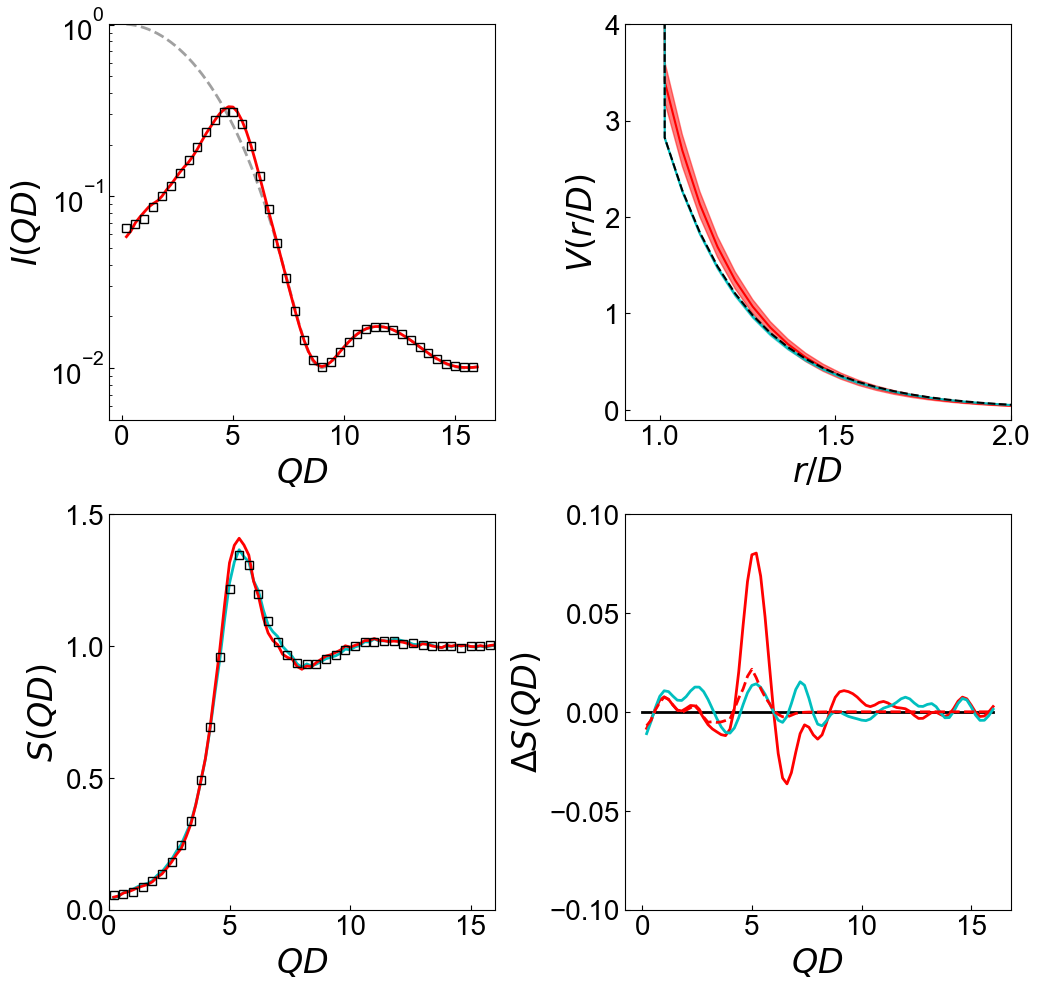

In [52]:
# combined figure
dict_kappa = loadmat('fp_A_fix.mat')
dict_kappa_SQ = loadmat('fp_A_SQ.mat')

fig = plt.figure(figsize=(10.5, 10))#,dpi=192)

index_MD = np.arange(5) +10
i = 1

fp_GT = dict_kappa['fp_GT_list'][i]

IQ_exp_GT = dict_kappa['IQ_exp_GT_list'][i]
SQ_exp_GT = dict_kappa['SQ_exp_GT_list'][i]
fp_opt_NN = dict_kappa['fp_opt_NN_list'][i]
fp_opt_RMSA = dict_kappa['fp_opt_RMSA_list'][i]
fp_err_NN = dict_kappa['fp_err_NN_list'][i]
fp_err_RMSA = dict_kappa['fp_err_RMSA_list'][i]

IQ_exp_GT_SQ = dict_kappa_SQ['IQ_exp_GT_list'][i]
SQ_exp_GT_SQ = dict_kappa_SQ['SQ_exp_GT_list'][i]
fp_opt_NN_SQ = dict_kappa_SQ['fp_opt_NN_list'][i]
fp_opt_RMSA_SQ = dict_kappa_SQ['fp_opt_RMSA_list'][i]
fp_err_NN_SQ = dict_kappa_SQ['fp_err_NN_list'][i]
fp_err_RMSA_SQ = dict_kappa_SQ['fp_err_RMSA_list'][i]

###### plot V(r) ######
ax = plt.subplot(2, 2, 2)

ur_GT = sample_potential_GT(fp_GT)
ur_NN, ur_NN_std = sample_potential(fp_opt_NN,fp_err_NN)
ur_RMSA, ur_RMSA_std = sample_potential(fp_opt_RMSA,fp_err_RMSA)

ur_NN_SQ, ur_NN_SQ_std = sample_potential(fp_opt_NN_SQ,fp_err_NN_SQ)
ur_RMSA_SQ, ur_RMSA_SQ_std = sample_potential(fp_opt_RMSA_SQ,fp_err_RMSA_SQ)

# V(r) from NN
ax.fill_between(rr,ur_NN+ur_NN_std,ur_NN-ur_NN_std,color='r',alpha=0.5)
ax.plot(rr,ur_NN,color='r')

# V(r) from NN, SQ fitting
ax.fill_between(rr,ur_NN_SQ+ur_NN_SQ_std,ur_NN_SQ-ur_NN_SQ_std,color='c',alpha=0.5)
ax.plot(rr,ur_NN_SQ,color='c')

ax.plot(rr,ur_GT,'--k')

#     ax.set_yscale('log')
ax.set_xlim(0.9,2.0)
ax.set_ylim(-0.1,4)
ax.set_xlabel(r'$r/D$',fontsize=24)
ax.set_ylabel(r'$V(r/D)$',fontsize=24)
ax.tick_params(direction='in', axis='both', which='both', labelsize=20)



###### plot I(Q) ######
ax = plt.subplot(2, 2, 1)

index_MD_i = index_MD[i]
filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
SQ_MD = load_SQ_MD(filename)
IQ_MD = IQ_exp(SQ_MD,fp_GT)

## P(Q)
ax.plot(q,hardsphere(q)*1**i+0.01,
        '--', lw=2, label='NN_MD', color='#A0A0A0')

# ## MD
# index_q = np.arange(40)*2
# ax.plot(q,IQ_MD*1**i,
#         ':', lw=2, label='NN_MD', color='r')

## fitting curve
ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*1**i,'-',
        label='NN', color='r', lw=2)

## GT
ax.plot(q[index_q],IQ_exp_GT[index_q]*1**i,
        's', color='k', fillstyle='none', lw=1, alpha=1,
        label='ground truth')
#     ax.errorbar(q[index_q],IQ_exp_GT[index_q]*1**i,IQ_exp_GT[index_q]*1**i*0.1,
#             alpha=1,fmt='none',color='k',capsize=2.0)


ax.set_yscale('log')
ax.set_ylim([5e-3,1.01e0])
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=24)
ax.set_ylabel(r'$I(QD)$',fontsize=24)
ax.tick_params(direction='in', axis='both', which='both', labelsize=20)



###### plot S(Q) ######
ax = plt.subplot(2, 2, 3)
# ax.plot(q,SQ_MD*1**i,
#         ':', lw=2, label='NN_MD', color='r')
ax.plot(q,SQ_NN(fp_opt_NN_SQ)*1**i,'-',
        label='NN', color='c', lw=2)
ax.plot(q,SQ_NN(fp_opt_NN)*1**i,'-',
        label='NN', color='r', lw=2)
ax.plot(q[index_q],SQ_exp_GT[index_q]*1**i,
        's', color='k', fillstyle='none', lw=1, alpha=1,
        label='ground truth')

#     ax.errorbar(q[index_q],SQ_exp_GT[index_q]*1**i,SQ_exp_GT[index_q]*1**i*0.1,
#             alpha=1,fmt='none',color='k',capsize=2.0)

ax.set_ylim([0,1.5])
ax.set_xlim([0,16])
ax.set_yticks([0,0.5,1,1.5])
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=24)
ax.set_ylabel(r'$S(QD)$',fontsize=24)
ax.tick_params(direction='in', axis='both', which='both', labelsize=20)


###### plot Residue ######
ax = plt.subplot(2, 2, 4)

ax.plot([0,16],[0,0],'-', color='k', lw=2) # baseline

# S(Q) from I(Q) fitting
ax.plot(q,(sm_GP(SQ_NN(fp_opt_NN),lmbda=0.75, sigma=0.1)-sm_GP(SQ_exp_GT,lmbda=0.75, sigma=0.1))*1**i,'-',
        label='NN', color='r', lw=2) # NN model fit
print('MSD SQ from IQ')
print(np.mean((sm_GP(SQ_NN(fp_opt_NN),lmbda=0.75, sigma=0.1)-sm_GP(SQ_exp_GT,lmbda=0.75, sigma=0.1))**2))

# S(Q) from S(Q) fitting
ax.plot(q,(sm_GP(SQ_NN(fp_opt_NN_SQ),lmbda=0.75, sigma=0.1)-sm_GP(SQ_exp_GT_SQ,lmbda=0.75, sigma=0.1))*1**i,'-',
        label='NN', color='c', lw=2) # NN model fit
print('MSD SQ from SQ')
print(np.mean((sm_GP(SQ_NN(fp_opt_NN_SQ),lmbda=0.75, sigma=0.1)-sm_GP(SQ_exp_GT_SQ,lmbda=0.75, sigma=0.1))**2))

# I(Q) from I(Q) fitting
ax.plot(q,(IQ_th(SQ_NN,fp_opt_NN)-IQ_exp_GT)*1**i,'--',
        label='NN', color='r', lw=2) # NN model fit
print('MSD IQ from IQ')
print(np.mean((IQ_th(SQ_NN,fp_opt_NN)-IQ_exp_GT)**2))


#     ax.set_yscale('log')
# ax.set_ylim([-1e-1,1e-1])
ax.set_yticks(np.linspace(-0.1,0.1,5))
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=24)
ax.set_ylabel(r'$\Delta S(QD)$',fontsize=24)
ax.tick_params(direction='in', axis='both', which='both', labelsize=20)

plt.tight_layout()
plt.show()

MSD SQ from IQ
0.00042060530179077824
MSD SQ from SQ
4.458394184752726e-05
MSD IQ from IQ
2.3262823700595838e-05


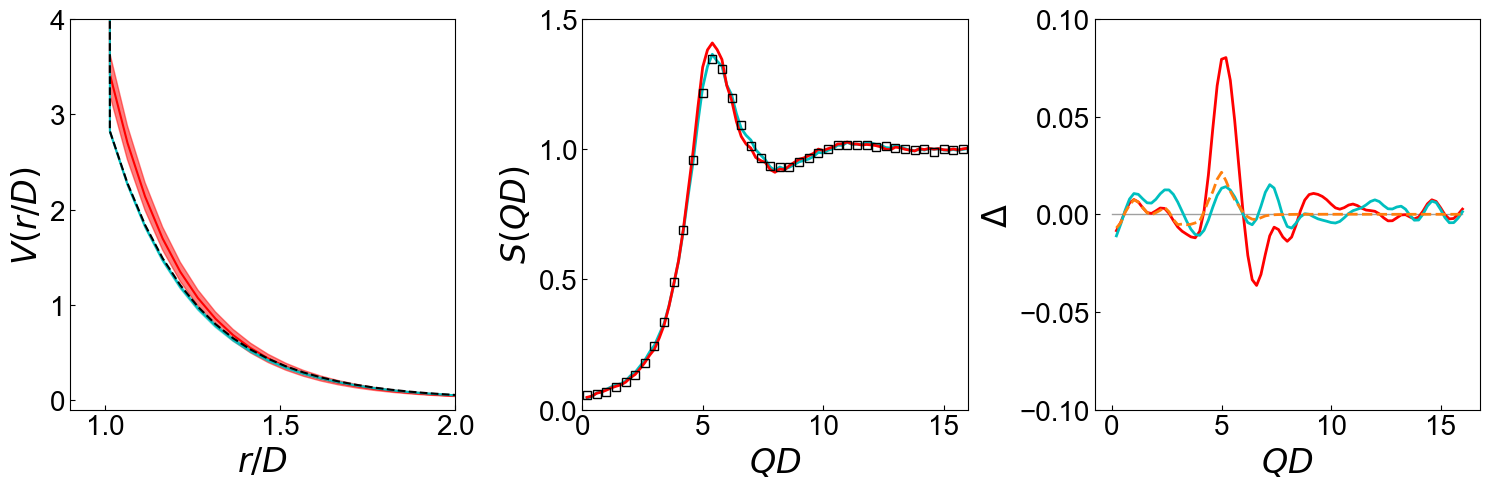

In [53]:
# combined figure
dict_kappa = loadmat('fp_A_fix.mat')
dict_kappa_SQ = loadmat('fp_A_SQ.mat')

fig = plt.figure(figsize=(15, 5))#,dpi=192)

index_MD = np.arange(5) +10
i = 1

fp_GT = dict_kappa['fp_GT_list'][i]

IQ_exp_GT = dict_kappa['IQ_exp_GT_list'][i]
SQ_exp_GT = dict_kappa['SQ_exp_GT_list'][i]
fp_opt_NN = dict_kappa['fp_opt_NN_list'][i]
fp_opt_RMSA = dict_kappa['fp_opt_RMSA_list'][i]
fp_err_NN = dict_kappa['fp_err_NN_list'][i]
fp_err_RMSA = dict_kappa['fp_err_RMSA_list'][i]

IQ_exp_GT_SQ = dict_kappa_SQ['IQ_exp_GT_list'][i]
SQ_exp_GT_SQ = dict_kappa_SQ['SQ_exp_GT_list'][i]
fp_opt_NN_SQ = dict_kappa_SQ['fp_opt_NN_list'][i]
fp_opt_RMSA_SQ = dict_kappa_SQ['fp_opt_RMSA_list'][i]
fp_err_NN_SQ = dict_kappa_SQ['fp_err_NN_list'][i]
fp_err_RMSA_SQ = dict_kappa_SQ['fp_err_RMSA_list'][i]

###### plot V(r) ######
ax = plt.subplot(1, 3, 1)

ur_GT = sample_potential_GT(fp_GT)
ur_NN, ur_NN_std = sample_potential(fp_opt_NN,fp_err_NN)
ur_RMSA, ur_RMSA_std = sample_potential(fp_opt_RMSA,fp_err_RMSA)

ur_NN_SQ, ur_NN_SQ_std = sample_potential(fp_opt_NN_SQ,fp_err_NN_SQ)
ur_RMSA_SQ, ur_RMSA_SQ_std = sample_potential(fp_opt_RMSA_SQ,fp_err_RMSA_SQ)

# V(r) from NN
ax.fill_between(rr,ur_NN+ur_NN_std,ur_NN-ur_NN_std,color='r',alpha=0.5)
ax.plot(rr,ur_NN,color='r')

# V(r) from NN, SQ fitting
ax.fill_between(rr,ur_NN_SQ+ur_NN_SQ_std,ur_NN_SQ-ur_NN_SQ_std,color='c',alpha=0.5)
ax.plot(rr,ur_NN_SQ,color='c')

ax.plot(rr,ur_GT,'--k')

#     ax.set_yscale('log')
ax.set_xlim(0.9,2.0)
ax.set_ylim(-0.1,4)
ax.set_xlabel(r'$r/D$',fontsize=24)
ax.set_ylabel(r'$V(r/D)$',fontsize=24)
ax.tick_params(direction='in', axis='both', which='both', labelsize=20)


###### plot S(Q) ######
ax = plt.subplot(1, 3, 2)
# ax.plot(q,SQ_MD*1**i,
#         ':', lw=2, label='NN_MD', color='r')
ax.plot(q,SQ_NN(fp_opt_NN_SQ)*1**i,'-',
        label='NN', color='c', lw=2)
ax.plot(q,SQ_NN(fp_opt_NN)*1**i,'-',
        label='NN', color='r', lw=2)
ax.plot(q[index_q],SQ_exp_GT[index_q]*1**i,
        's', color='k', fillstyle='none', lw=1, alpha=1,
        label='ground truth')

#     ax.errorbar(q[index_q],SQ_exp_GT[index_q]*1**i,SQ_exp_GT[index_q]*1**i*0.1,
#             alpha=1,fmt='none',color='k',capsize=2.0)

ax.set_ylim([0,1.5])
ax.set_xlim([0,16])
ax.set_yticks([0,0.5,1,1.5])
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=24)
ax.set_ylabel(r'$S(QD)$',fontsize=24)
ax.tick_params(direction='in', axis='both', which='both', labelsize=20)


###### plot Residue ######
ax = plt.subplot(1, 3, 3)

ax.plot([0,16],[0,0],'-', color='#A0A0A0', lw=1) # baseline

# S(Q) from I(Q) fitting
ax.plot(q,(sm_GP(SQ_NN(fp_opt_NN),lmbda=0.75, sigma=0.1)-sm_GP(SQ_exp_GT,lmbda=0.75, sigma=0.1))*1**i,'-',
        label='NN', color='r', lw=2) # NN model fit
print('MSD SQ from IQ')
print(np.mean((sm_GP(SQ_NN(fp_opt_NN),lmbda=0.75, sigma=0.1)-sm_GP(SQ_exp_GT,lmbda=0.75, sigma=0.1))**2))

# S(Q) from S(Q) fitting
ax.plot(q,(sm_GP(SQ_NN(fp_opt_NN_SQ),lmbda=0.75, sigma=0.1)-sm_GP(SQ_exp_GT_SQ,lmbda=0.75, sigma=0.1))*1**i,'-',
        label='NN', color='c', lw=2) # NN model fit
print('MSD SQ from SQ')
print(np.mean((sm_GP(SQ_NN(fp_opt_NN_SQ),lmbda=0.75, sigma=0.1)-sm_GP(SQ_exp_GT_SQ,lmbda=0.75, sigma=0.1))**2))

# I(Q) from I(Q) fitting
ax.plot(q,(IQ_th(SQ_NN,fp_opt_NN)-IQ_exp_GT)*1**i,'--',
        label='NN', color='tab:orange', lw=2) # NN model fit
print('MSD IQ from IQ')
print(np.mean((IQ_th(SQ_NN,fp_opt_NN)-IQ_exp_GT)**2))


#     ax.set_yscale('log')
# ax.set_ylim([-1e-1,1e-1])
ax.set_yticks(np.linspace(-0.1,0.1,5))
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=24)
ax.set_ylabel(r'$\Delta$',fontsize=24)
ax.tick_params(direction='in', axis='both', which='both', labelsize=20)

plt.tight_layout()
plt.show()

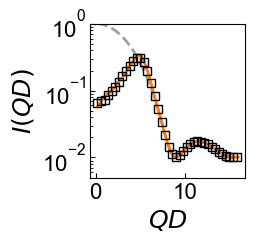

In [86]:
# I(Q) inset
dict_A = loadmat('fp_A_fix.mat')
dict_A_SQ = loadmat('fp_A_SQ.mat')

index_MD = np.arange(5) +10
i = 1

fp_GT = dict_A['fp_GT_list'][i]

IQ_exp_GT = dict_A['IQ_exp_GT_list'][i]
SQ_exp_GT = dict_A['SQ_exp_GT_list'][i]
fp_opt_NN = dict_A['fp_opt_NN_list'][i]
fp_opt_RMSA = dict_A['fp_opt_RMSA_list'][i]
fp_err_NN = dict_A['fp_err_NN_list'][i]
fp_err_RMSA = dict_A['fp_err_RMSA_list'][i]

IQ_exp_GT_SQ = dict_A_SQ['IQ_exp_GT_list'][i]
SQ_exp_GT_SQ = dict_A_SQ['SQ_exp_GT_list'][i]
fp_opt_NN_SQ = dict_A_SQ['fp_opt_NN_list'][i]
fp_opt_RMSA_SQ = dict_A_SQ['fp_opt_RMSA_list'][i]
fp_err_NN_SQ = dict_A_SQ['fp_err_NN_list'][i]
fp_err_RMSA_SQ = dict_A_SQ['fp_err_RMSA_list'][i]

fig = plt.figure(figsize=(2,2))#,dpi=192)
###### plot I(Q) ######
ax = plt.subplot(1, 1, 1)

index_MD_i = index_MD[i]
filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
SQ_MD = load_SQ_MD(filename)
IQ_MD = IQ_exp(SQ_MD,fp_GT)

## P(Q)
ax.plot(q,hardsphere(q)*1**i+0.01,
        '--', lw=2, label='NN_MD', color='#A0A0A0')

# ## MD
# index_q = np.arange(40)*2
# ax.plot(q,IQ_MD*1**i,
#         ':', lw=2, label='NN_MD', color='r')

## fitting curve
ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*1**i,'-',
        label='NN', color='tab:orange', lw=2)

## GT
ax.plot(q[index_q],IQ_exp_GT[index_q]*1**i,
        's', color='k', fillstyle='none', lw=1, alpha=1,
        label='ground truth')
#     ax.errorbar(q[index_q],IQ_exp_GT[index_q]*1**i,IQ_exp_GT[index_q]*1**i*0.1,
#             alpha=1,fmt='none',color='k',capsize=2.0)


ax.set_yscale('log')
ax.set_ylim([5e-3,1.01e0])
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

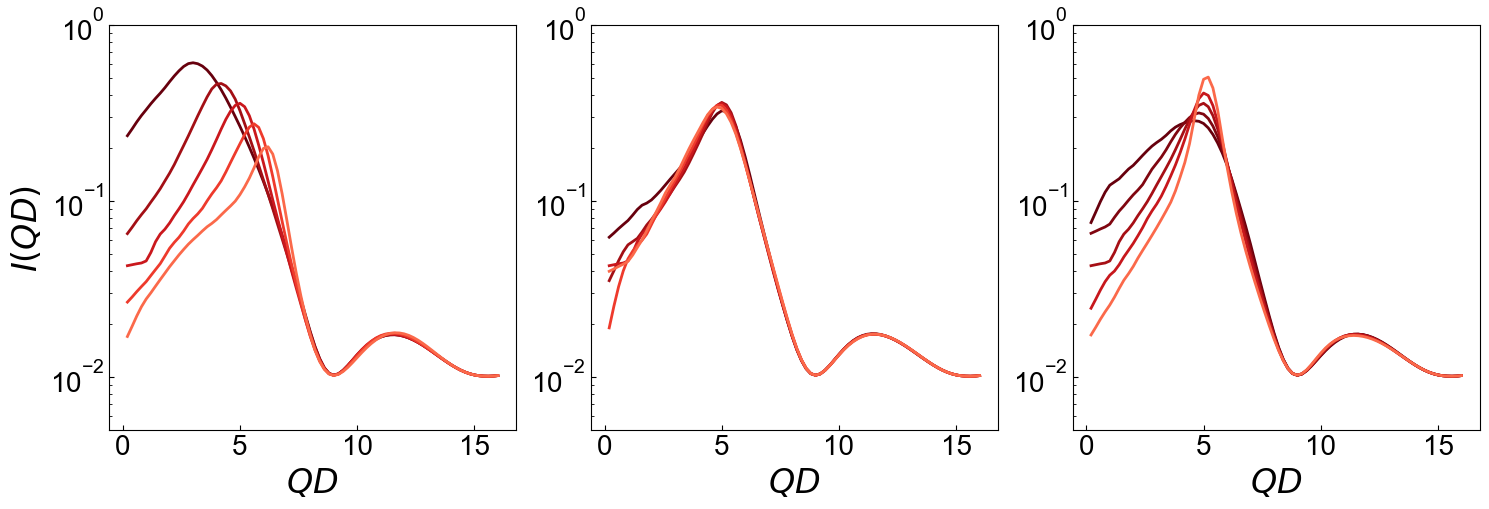

In [55]:
# eta, overlapped
# NN fitting curve and MD invertion
dict_loaded_list = [loadmat('fp_eta_fix.mat'),loadmat('fp_kappa_fix.mat'),loadmat('fp_A_fix.mat')]
p_color_list = [eta_list,kappa_list,A_list]

fig = plt.figure(figsize=(15, 5.2))#,dpi=192)

for i_dict in range(3):
    dict_loaded = dict_loaded_list[i_dict]
    p_color = p_color_list[i_dict]
    index_MD = np.arange(5) +5*i_dict
    for i in range(len(parameters_list)):
        ax = plt.subplot(1, 3, i_dict+1)

        fp_GT = dict_loaded['fp_GT_list'][i]
        fp_opt_NN = dict_loaded['fp_opt_NN_list'][i]
        fp_opt_RMSA = dict_loaded['fp_opt_RMSA_list'][i]
        fp_err_NN = dict_loaded['fp_err_NN_list'][i]
        fp_err_RMSA = dict_loaded['fp_err_RMSA_list'][i]
        IQ_exp_GT = dict_loaded['IQ_exp_GT_list'][i]

        r = (1-(fp_GT[i_dict]-p_color[0])/(p_color[-1]-p_color[0]))*0.5+0.5
        c_NN = cmap_NN(r)
        c_RMSA = cmap_RMSA(r)

        index_MD_i = index_MD[i]
        filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
        SQ_MD = load_SQ_MD(filename)
        IQ_MD = IQ_exp(SQ_MD,fp_GT)

        ax.plot(q,IQ_exp_GT,c=c_NN,lw=2,
                label='ground truth')

        ax.set_yscale('log')
        ax.set_ylim([5e-3,1e0])

    ax.set_xlabel(r'$QD$',fontsize=24)
    if i_dict==0:
        ax.set_ylabel(r'$I(QD)$',fontsize=24)
    ax.tick_params(direction='in', axis='both', which='both', labelsize=20)

plt.tight_layout()
plt.show()

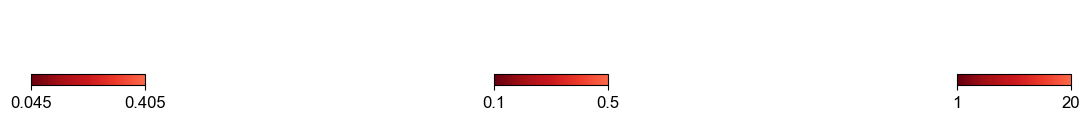

In [63]:
# eta, overlapped
# NN fitting curve and MD invertion
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
dict_loaded_list = [loadmat('fp_eta_fix.mat'),loadmat('fp_kappa_fix.mat'),loadmat('fp_A_fix.mat')]
p_color_list = [eta_list,kappa_list,A_list]
title_list = [r'$\hat{\phi}$',r'$1/\hat{\kappa} D$',r'$\beta \hat{A}D$']

fig = plt.figure(figsize=(15, 2))#,dpi=192)

for i_dict in range(3):
    ax = plt.subplot(1, 3, i_dict+1)
    dict_loaded = dict_loaded_list[i_dict]
    p_color = p_color_list[i_dict]
    index_MD = np.arange(5) +5*i_dict
    
    r_list = np.arange(100)/100
    c_map_list = cmap_NN((1-r_list)*0.5+0.5)
    c_map_new = ListedColormap(c_map_list)
    c_map_white = ListedColormap(np.ones((2,4)))
    
    for i in range(len(parameters_list)):
        fp_GT = dict_loaded['fp_GT_list'][i]

        r = (1-(fp_GT[i_dict]-p_color[0])/(p_color[-1]-p_color[0]))*0.5+0.5
        c_NN = cmap_NN(r)

        im = ax.imshow(p_color_list[i_dict].reshape((5,1)),cmap=c_map_new)
        im_w = ax.imshow(p_color_list[i_dict].reshape((5,1)),cmap=c_map_white)
        
    plt.axis('off')    
    cbar = fig.colorbar(im, ticks=p_color[[0,4]], aspect=10, orientation='horizontal')
    cbar.ax.tick_params(labelsize=12)
#     cbar.set_label(title_list[i_dict],fontsize=12,loc='center')
    
plt.subplots_adjust(bottom=0.5, right=1)
plt.show()

In [57]:
c_map_list

array([[0.40392157, 0.        , 0.05098039, 1.        ],
       [0.4115494 , 0.00184544, 0.05196463, 1.        ],
       [0.41917724, 0.00369089, 0.05294887, 1.        ],
       [0.42680507, 0.00553633, 0.0539331 , 1.        ],
       [0.44206075, 0.00922722, 0.05590158, 1.        ],
       [0.44968858, 0.01107266, 0.05688581, 1.        ],
       [0.45731642, 0.01291811, 0.05787005, 1.        ],
       [0.46494425, 0.01476355, 0.05885429, 1.        ],
       [0.48019992, 0.01845444, 0.06082276, 1.        ],
       [0.48782776, 0.02029988, 0.061807  , 1.        ],
       [0.49545559, 0.02214533, 0.06279123, 1.        ],
       [0.51071126, 0.02583622, 0.06475971, 1.        ],
       [0.5183391 , 0.02768166, 0.06574394, 1.        ],
       [0.52596694, 0.0295271 , 0.06672818, 1.        ],
       [0.53359477, 0.03137255, 0.06771242, 1.        ],
       [0.54885044, 0.03506344, 0.06968089, 1.        ],
       [0.55647828, 0.03690888, 0.07066513, 1.        ],
       [0.56410611, 0.03875433,

## parameter accuracy

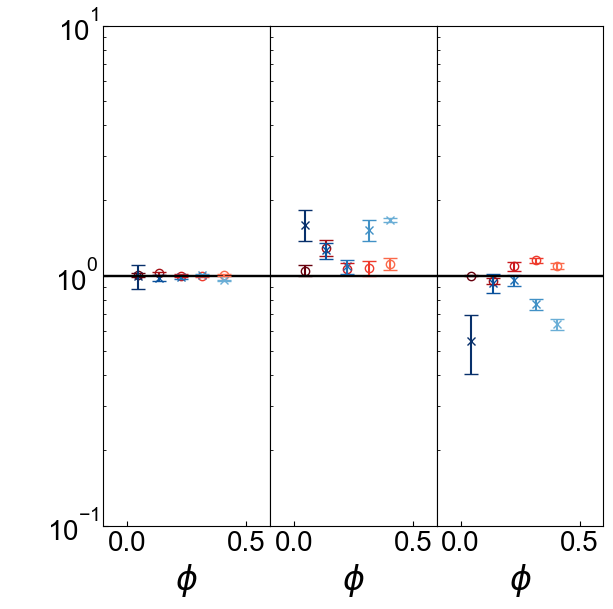

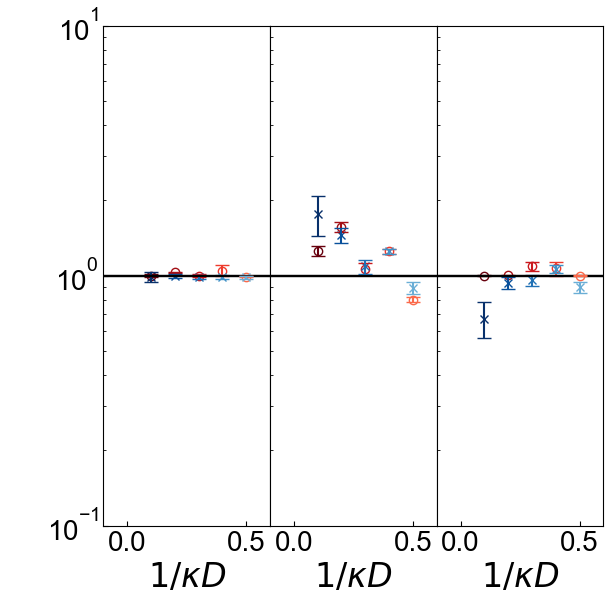

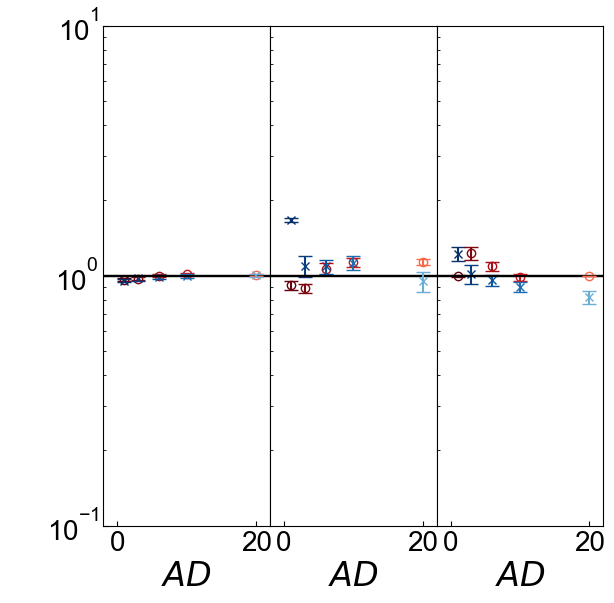

In [38]:
dict_loaded_list = [loadmat('fp_eta_fix.mat'),loadmat('fp_kappa_fix.mat'),loadmat('fp_A_fix.mat')]
p_color_list = [eta_list,kappa_list,A_list]
index_list = [0,1,2]
tick_labels = [r'$\phi$',r'$1/\kappa D$',r'$AD$',r'$\sigma$',r'$C$',r'$I_{\it{inc}}$',
                           r'$Z$',r'$x_{V}$',r'$\Gamma_{is}$']

ticks_list = p_color_list
xlim = [[-0.1,0.6],[-0.1,0.6],[-2,22]]

for i_dict in range(3):
    fig = plt.figure(figsize=(5, 5))#,dpi=192)
    dict_loaded = dict_loaded_list[i_dict]
    p_color = p_color_list[i_dict]
    for i_index in range(len(index_list)):
        for i in range(len(parameters_list)):
            ax = plt.subplot(1, 3, i_index+1)

            fp_GT = dict_loaded['fp_GT_list'][i]
            fp_opt_NN = dict_loaded['fp_opt_NN_list'][i]
            fp_opt_RMSA = dict_loaded['fp_opt_RMSA_list'][i]
            fp_err_NN = dict_loaded['fp_err_NN_list'][i]
            fp_err_RMSA = dict_loaded['fp_err_RMSA_list'][i]

            r = (1-(fp_GT[i_dict]-p_color[0])/(p_color[-1]-p_color[0]))*0.5+0.5
            c_NN = cmap_NN(r)
            c_RMSA = cmap_RMSA(r)

        #     index = np.r_[index_free,6,7,8]
            index = i_index
            ax.plot(fp_GT[i_dict],fp_opt_NN[index]/fp_GT[index],'o', fillstyle='none',
                    label='NN', color=c_NN)
            ax.plot(fp_GT[i_dict],fp_opt_RMSA[index]/fp_GT[index],'x',
                    label='RMSA', color=c_RMSA)
            ax.plot([min(ticks_list[i_dict])-20,max(ticks_list[i_dict])+20],[1,1],'-k')

            index_err = i_index
            ax.errorbar(fp_GT[i_dict],fp_opt_NN[index_err]/fp_GT[index_err], 
                        abs(fp_err_NN[index_err]/fp_GT[index_err]),
                   fmt='none',color=c_NN,capsize=5.0)
            ax.errorbar(fp_GT[i_dict],fp_opt_RMSA[index_err]/fp_GT[index_err], 
                        abs(fp_err_RMSA[index_err]/fp_GT[index_err]),
                   fmt='none',color=c_RMSA,capsize=5.0)

            ax.set_yscale('log')
            #     ax.legend(fontsize=16,frameon=False,fancybox=False)
            xrange = max(ticks_list[i_dict])-min(ticks_list[i_dict])
            ax.set_xlim(xlim[i_dict])
            ax.set_ylim([1e-1,1e1])
            
            if i_index>0:
                ax.set_yticks([])
            
#             ax.set_xticks(ticks_list[i_dict])
#             ax.set_xticklabels([tick_labels[it] for it in index_list])

            ax.set_xlabel(tick_labels[i_dict],fontsize=24)
            ax.set_ylabel(' ',fontsize=24)
            ax.tick_params(direction='in', axis='both', which='both', labelsize=20)
            
            plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

plt.show()

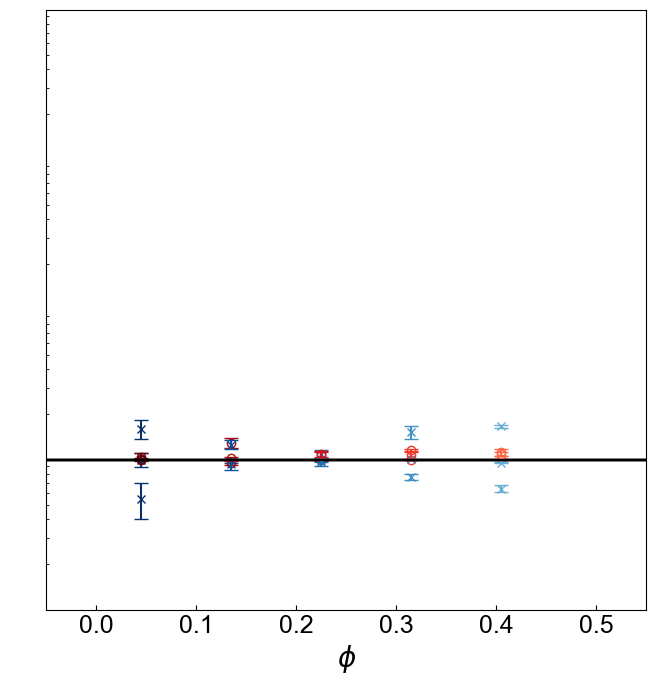

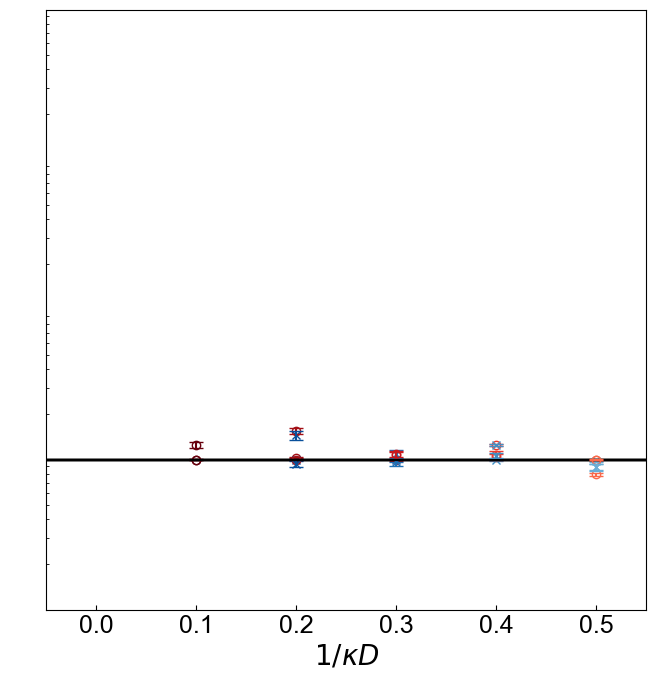

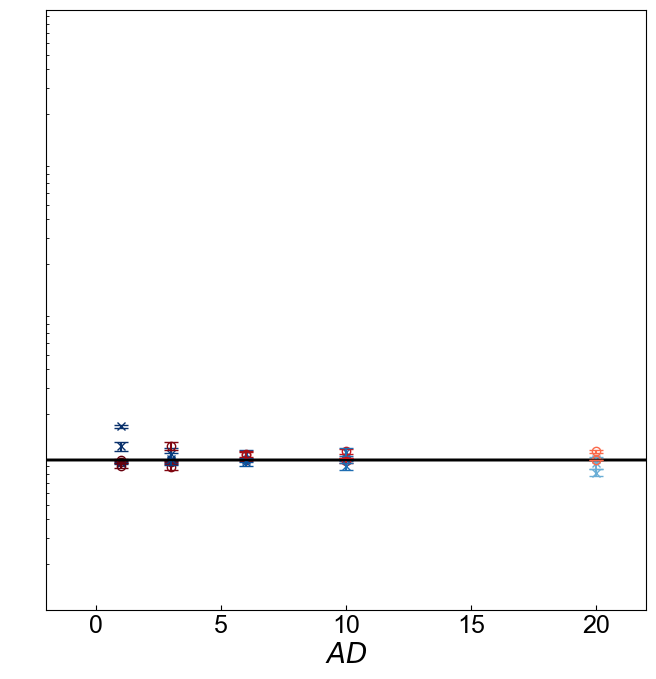

In [35]:
dict_loaded_list = [loadmat('fp_eta_fix.mat'),loadmat('fp_kappa_fix.mat'),loadmat('fp_A_fix.mat')]
p_color_list = [eta_list,kappa_list,A_list]
index_list = [0,1,2]
tick_labels = [r'$\phi$',r'$1/\kappa D$',r'$AD$',r'$\sigma$',r'$C$',r'$I_{\it{inc}}$',
                           r'$Z$',r'$x_{V}$',r'$\Gamma_{is}$']

ticks_list = p_color_list
xlim = [[-0.05,0.55],[-0.05,0.55],[-2,22]]

for i_dict in range(3):
    fig = plt.figure(figsize=(6, 6))#,dpi=192)
    dict_loaded = dict_loaded_list[i_dict]
    p_color = p_color_list[i_dict]
    for i_index in range(len(index_list)):
        for i in range(len(parameters_list)):
            ax = plt.subplot(1, 1, 1)

            fp_GT = dict_loaded['fp_GT_list'][i]
            fp_opt_NN = dict_loaded['fp_opt_NN_list'][i]
            fp_opt_RMSA = dict_loaded['fp_opt_RMSA_list'][i]
            fp_err_NN = dict_loaded['fp_err_NN_list'][i]
            fp_err_RMSA = dict_loaded['fp_err_RMSA_list'][i]

            r = (1-(fp_GT[i_dict]-p_color[0])/(p_color[-1]-p_color[0]))*0.5+0.5
            c_NN = cmap_NN(r)
            c_RMSA = cmap_RMSA(r)

        #     index = np.r_[index_free,6,7,8]
            index = i_index
            ax.plot(fp_GT[i_dict],fp_opt_NN[index]/fp_GT[index],'o', fillstyle='none',
                    label='NN', color=c_NN)
            ax.plot(fp_GT[i_dict],fp_opt_RMSA[index]/fp_GT[index],'x',
                    label='RMSA', color=c_RMSA)
            ax.plot([min(ticks_list[i_dict])-xrange,max(ticks_list[i_dict])+xrange],[1,1],'-k')

            index_err = i_index
            ax.errorbar(fp_GT[i_dict],fp_opt_NN[index_err]/fp_GT[index_err], 
                        abs(fp_err_NN[index_err]/fp_GT[index_err]),
                   fmt='none',color=c_NN,capsize=5.0)
            ax.errorbar(fp_GT[i_dict],fp_opt_RMSA[index_err]/fp_GT[index_err], 
                        abs(fp_err_RMSA[index_err]/fp_GT[index_err]),
                   fmt='none',color=c_RMSA,capsize=5.0)

            ax.set_yscale('log')
            #     ax.legend(fontsize=16,frameon=False,fancybox=False)
            xrange = max(ticks_list[i_dict])-min(ticks_list[i_dict])
            ax.set_xlim(xlim[i_dict])
            ax.set_ylim([1e-1,1e3])
            
            if i_index>0:
                ax.set_yticks([])
            
#             ax.set_xticks(ticks_list[i_dict])
#             ax.set_xticklabels([tick_labels[it] for it in index_list])

            ax.set_xlabel(tick_labels[i_dict],fontsize=20)
            ax.set_ylabel(' ',fontsize=20)
            ax.tick_params(direction='in', axis='both', which='both', labelsize=18)
            
            plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

plt.show()

In [60]:
dict_patameter_list = [dict_eta,dict_kappa,dict_A]
def print_table_MD(dict_patameter):
    with open('table_MD_GT.txt', 'a') as f:
        for i in range(len(parameters_list)):

            fp_GT = dict_patameter['fp_GT_list'][i]
            fp_opt_NN = dict_patameter['fp_opt_NN_list'][i]
            fp_opt_RMSA = dict_patameter['fp_opt_RMSA_list'][i]
            fp_err_NN = dict_patameter['fp_err_NN_list'][i]
            fp_err_RMSA = dict_patameter['fp_err_RMSA_list'][i]

        #     #relative error
        #     fp_NN_err = (fp_opt_NN-fp_GT)/fp_GT
        #     fp_NN_RMSA = (fp_opt_RMSA-fp_GT)/fp_GT

            index_print = [0,1,2]

            string = ''
            for j in index_print:
                string += '{:0.3f},'.format(fp_GT[j])
            string_row = string+'\n'
            print(string_row)
            f.write(string_row)
            
for i in dict_patameter_list:
    print_table_MD(i)

0.045,0.300,6.000,

0.135,0.300,6.000,

0.225,0.300,6.000,

0.315,0.300,6.000,

0.405,0.300,6.000,

0.225,0.300,1.000,

0.225,0.300,3.000,

0.225,0.300,6.000,

0.225,0.300,10.000,

0.225,0.300,20.000,

0.225,0.300,1.000,

0.225,0.300,3.000,

0.225,0.300,6.000,

0.225,0.300,10.000,

0.225,0.300,20.000,



In [84]:
dict_loaded_list = [loadmat('fp_eta_fix.mat'),loadmat('fp_kappa_fix.mat'),loadmat('fp_A_fix.mat')]
parameters = []
for dict_patameter in dict_loaded_list:
    for i in range(len(parameters_list)):

        fp_GT = dict_patameter['fp_GT_list'][i]

        index_print = [0,1,2]
        parameters.append(fp_GT[index_print])
parameters = np.array(parameters)
from scipy.io import savemat
filename = 'parameters_benchmark.mat'
mdic={'parameters_grid':parameters}
savemat(filename, mdic)

In [85]:
parameters

array([[ 0.045,  0.3  ,  6.   ],
       [ 0.135,  0.3  ,  6.   ],
       [ 0.225,  0.3  ,  6.   ],
       [ 0.315,  0.3  ,  6.   ],
       [ 0.405,  0.3  ,  6.   ],
       [ 0.225,  0.1  ,  6.   ],
       [ 0.225,  0.2  ,  6.   ],
       [ 0.225,  0.3  ,  6.   ],
       [ 0.225,  0.4  ,  6.   ],
       [ 0.225,  0.5  ,  6.   ],
       [ 0.225,  0.3  ,  1.   ],
       [ 0.225,  0.3  ,  3.   ],
       [ 0.225,  0.3  ,  6.   ],
       [ 0.225,  0.3  , 10.   ],
       [ 0.225,  0.3  , 20.   ]])

In [80]:
dict_kappa = loadmat('fp_kappa_fix.mat')
dict_kappa['fp_GT_list'][:,0:3]


array([[0.225, 0.1  , 6.   ],
       [0.225, 0.2  , 6.   ],
       [0.225, 0.3  , 6.   ],
       [0.225, 0.4  , 6.   ],
       [0.225, 0.5  , 6.   ]])

In [83]:
dict_loaded_list[1]

{'__header__': b'MATLAB 5.0 MAT-file Platform: nt, Created on: Tue May  9 20:14:19 2023',
 '__version__': '1.0',
 '__globals__': [],
 'fp_GT_list': array([[ 2.25000000e-01,  1.00000000e-01,  6.00000000e+00,
          1.00000000e+00,  1.00000000e+00,  1.00000000e-02,
          1.46969385e+01,  8.65302163e-01,  2.06208112e+00],
        [ 2.25000000e-01,  2.00000000e-01,  6.00000000e+00,
          1.00000000e+00,  1.00000000e+00,  1.00000000e-02,
          8.57321410e+00,  7.57274832e-01,  4.76001436e-01],
        [ 2.25000000e-01,  3.00000000e-01,  6.00000000e+00,
          1.00000000e+00,  1.00000000e+00,  1.00000000e-02,
          6.53197265e+00,  6.71828978e-01, -5.26917923e-02],
        [ 2.25000000e-01,  4.00000000e-01,  6.00000000e+00,
          1.00000000e+00,  1.00000000e+00,  1.00000000e-02,
          5.51135192e+00,  6.04608021e-01, -3.17038406e-01],
        [ 2.25000000e-01,  5.00000000e-01,  6.00000000e+00,
          1.00000000e+00,  1.00000000e+00,  1.00000000e-02,
         

## New Fig. 3

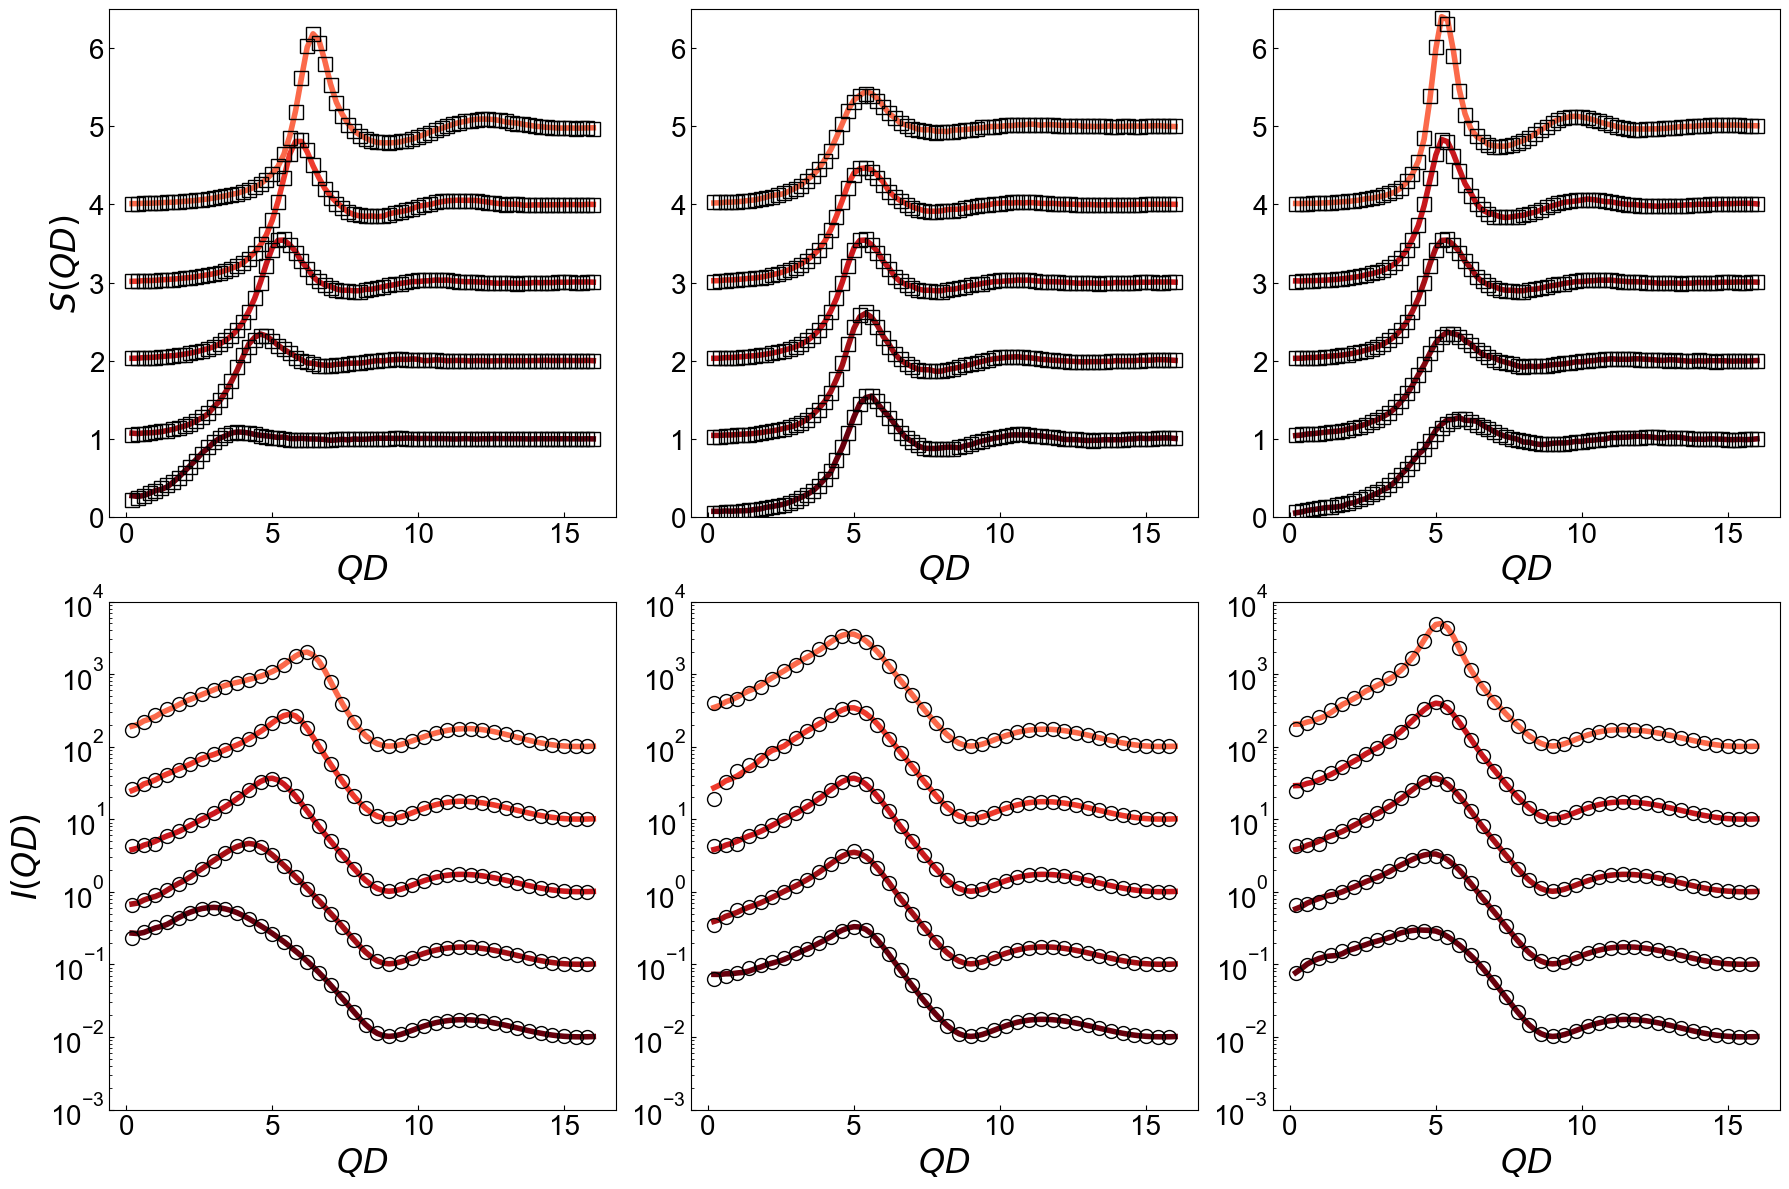

In [83]:
# eta, overlapped
# NN fitting curve and MD invertion
dict_loaded_list = [loadmat('fp_eta_fix.mat'),loadmat('fp_kappa_fix.mat'),loadmat('fp_A_fix.mat')]
p_color_list = [eta_list,kappa_list,A_list]

fig = plt.figure(figsize=(18, 12))#,dpi=192)

for i_dict in range(3):
    dict_loaded = dict_loaded_list[i_dict]
    p_color = p_color_list[i_dict]
    index_MD = np.arange(5) +5*i_dict
    for i in range(len(parameters_list)):
        ax = plt.subplot(2, 3, i_dict+1)

        fp_GT = dict_loaded['fp_GT_list'][i]
        fp_opt_NN = dict_loaded['fp_opt_NN_list'][i]
        fp_opt_RMSA = dict_loaded['fp_opt_RMSA_list'][i]
        fp_err_NN = dict_loaded['fp_err_NN_list'][i]
        fp_err_RMSA = dict_loaded['fp_err_RMSA_list'][i]
        IQ_exp_GT = dict_loaded['IQ_exp_GT_list'][i]

        r = (1-(fp_GT[i_dict]-p_color[0])/(p_color[-1]-p_color[0]))*0.5+0.5
        c_NN = cmap_NN(r)
        c_RMSA = cmap_RMSA(r)

        index_MD_i = index_MD[i]
        filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
        SQ_MD = load_SQ_MD(filename)
        IQ_MD = IQ_exp(SQ_MD,fp_GT)
        
        SQ_exp_GT = dict_loaded['SQ_exp_GT_list'][i]+i
        SQ_exp_NN = SQ_NN(fp_GT)+i
        
        ax.plot(q,SQ_exp_NN,
                '-', lw=4, label='NN', color=c_NN)
        ax.plot(q,SQ_exp_GT,
                's', color='k', fillstyle='none', lw=2, ms=10,
                label='ground truth')
        
    
    # ax.set_yscale('log')
    ax.set_ylim([0,6.5])
    ax.set_xlabel(r'$QD$',fontsize=24)
    if i_dict==0:
        ax.set_ylabel(r'$S(QD)$',fontsize=24)
    ax.tick_params(direction='in', axis='both', which='both', labelsize=20)
    
for i_dict in range(3):
    dict_loaded = dict_loaded_list[i_dict]
    p_color = p_color_list[i_dict]
    index_MD = np.arange(5) +5*i_dict
    for i in range(len(parameters_list)):
        ax = plt.subplot(2, 3, i_dict+4)

        fp_GT = dict_loaded['fp_GT_list'][i]
        fp_opt_NN = dict_loaded['fp_opt_NN_list'][i]
        fp_opt_RMSA = dict_loaded['fp_opt_RMSA_list'][i]
        fp_err_NN = dict_loaded['fp_err_NN_list'][i]
        fp_err_RMSA = dict_loaded['fp_err_RMSA_list'][i]
        IQ_exp_GT = dict_loaded['IQ_exp_GT_list'][i]

        r = (1-(fp_GT[i_dict]-p_color[0])/(p_color[-1]-p_color[0]))*0.5+0.5
        c_NN = cmap_NN(r)
        c_RMSA = cmap_RMSA(r)

        index_MD_i = index_MD[i]
        filename = glob('./MD/fixed_c/'+str(index_MD_i)+'__*/'+'soq.txt')[0]
        SQ_MD = load_SQ_MD(filename)
        IQ_MD = IQ_exp(SQ_MD,fp_GT)
        
        SQ_exp_GT = dict_loaded['SQ_exp_GT_list'][i]+i
        SQ_exp_NN = SQ_NN(fp_GT)+i
        
        
        ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*10**i,'-',
                label='NN', color=c_NN, lw=4)
        index_q = np.arange(40)*2
        ax.plot(q[index_q],IQ_exp_GT[index_q]*10**i,
            'o', color='k', fillstyle='none', lw=2, alpha=1, ms=10,
            label='ground truth')
    
    ax.set_yscale('log')
    ax.set_ylim([1e-3,1e4])

    
    ax.tick_params(direction='in', axis='both', which='both', labelsize=20)
    ax.set_xlabel(r'$QD$',fontsize=24)
    if i_dict==0:
        ax.set_ylabel(r'$I(QD)$',fontsize=24)

plt.tight_layout()
plt.show()